##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import clear_output
# from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.externals import joblib
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass



from ipywidgets import FloatProgress, HTML

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))


# FirstRun = True
# FirstRun = False
aliases={'wind_speed':'$\overline{U}$','PPFD_Avg':'PPFD',
        'AirTC_Avg':'T$_{a}$','Out_of_Basin':'F$_{out}$','Upland':'F$_{up}$',
        'Sedge':'F$_{sdg}$','air_pressure':'P$_{a}$',
        'Shrub':'F$_{shb}$','Sparse':'F$_{spr}$','Grass':'F$_{grs}$'
         ,'Temp':'T$_{s}$','H':'$H$','VPD':'VPD','VWC':'$VWC$',
        'Water Table': 'W$_{TBL}$','Active Layer':'AL',
        'Wind Spd':'$\overline{U}$','24H Rain':'24HR','Wtr Tbl Trnd':'d Wtr Tbl',
        'air pressure':'P$_{a}$','Ta':'T$_{a}$','Rn':'Rn','PPFD':'PPFD','Rain':'Rain',
        'Ts 2.5 cm':'T$_{2.5cm}$','Ts 15 cm':'T$_{15cm}$','(z-d)/L':'Stability'}

pd.set_option('max_colwidth',200)
MP=True

cwd = os.getcwd()
Site='Illisarvik'

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def Performance(ax,title,target):
    ax.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
           yerr=target.level_best['SE'].values*target.SE_Rule,
           color='grey',
        alpha = .8,label='Best model at\neach size')
    ax.bar(target.Best['Size'].values,target.Best['MSE'].values,
           yerr=target.Best['SE'].values*target.SE_Rule,
           color='red',
           alpha = 1,
           label='Parsimony')
    yaxy = ax.twiny()
    yaxy.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
             yerr=target.level_best['SE'].values*target.SE_Rule,
             color='grey',
             alpha = 0,label=None)
    yaxy.set_xlabel('Number of Factors')
#     ax.set_ylabel('MSE')
    ax.set_xlabel('Additional Model Input')
    ax.set_title(title,y=1.1,loc='left')
    ax.plot([target.level_best['Size'].min(),target.level_best['Size'].max()],
            [target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.SE_Rule,
            target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.SE_Rule])
    plt.sca(ax)
    plt.grid()
    
    i=1
    Labs = []
    for mod in target.level_best.Model.unique():
        if i >1:
            Labs.append([val for val in mod.split('+') if val not in modold.split('+')][0])
        else:
            Labs.append(mod)
        modold=mod
        i+=1
    labels = []
    for lab in Labs:
        labels.append(aliases[lab])
    plt.xticks(target.level_best['Size'],labels,rotation=90)
    print(target.Best)
    
def LevelPerformance(ax,title,target,level=1,SE_Rule=1):
    Data = target.Records.loc[target.Records['Size']==level].sort_values('MSE').reset_index()
    
    if level == 1:
        Data['Name']=Data['Model']
        for val in Data['Model']:
            Data.loc[Data['Model']==val,'Name']=aliases[val]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]
        Best = Data[Data['MSE']<=Myax]
        ax.bar(Data['Name'],Data['MSE'].values,
               yerr=Data['SE'].values*target.SE_Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best['Name'],Best['MSE'].values,
               yerr=Best['SE'].values*target.SE_Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min['Name'],Min['MSE'].values,
               yerr=Min['SE'].values*target.SE_Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
        print(Best)
    else:
        alpha = .025
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]
        Best = Data[Data['MSE']<= Myax]
        ax.bar(Data.index,Data['MSE'].values,
               yerr=Data['SE'].values*target.SE_Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best.index,Best['MSE'].values,
               yerr=Best['SE'].values*target.SE_Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min.index,Min['MSE'].values,
               yerr=Min['SE'].values*target.SE_Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
#         print(Best)
        print()
        print(Data)
    ax.plot([Data.index[0],Data.index[-1]],[Myax,Myax])
#         print()
    ax.grid()

def Mapper(AllData,target,target_name,DarkTarget=None):
    target.Project(Projector = None,
                Model = None)
    if DarkTarget is None:
        target.RST.Data = AllData
    else:
        target.RST.Data = DarkTarget
    target.RST.Scale(target.params['target'],
                   target.params['Inputs'],
                   ScalePath=target.params['Spath'],
                   Project=True)
    target.Map()
    AllData[target_name] = target.Data_Map[target.target].values
    AllData[target_name+'_Var_reg'] = target.Data_Map['Var_reg'].values
    AllData[target_name+'_Var_er'] = target.Data_Map['Var_er'].values
    AllData[target_name+'_CI'] = target.Data_Map['CI'].values
    AllData[target_name+'_PI'] = target.Data_Map['PI'].values
    return(AllData)
def PooledVar_interval(T30,Vars,target,mean):
    n = target.params['K']
    T30['Pooled_Var']=T30[Vars].sum(axis=1)
    Sp = (n-1)*T30['Pooled_Var'].sum()/((n-1)*T30.shape[0])
    return(Sp)

def Pooledstd_interval_pop(T30,Vars,target,mean):
    n = target.params['K']
    T30['Pooled_Var']=T30[Vars].sum(axis=1)
    Term1 = T30['Pooled_Var'].mean()
    df1 = pd.DataFrame((np.subtract.outer(T30[mean], T30[mean]))**2*n*n, T30.index, T30.index)
    Term2 = (df1.stack().sum()/((T30[mean].shape[0]*n)**2))
    Sp = Term1+Term2
    return(Sp)


def PooledVar_interval(T30,Vars,target,mean): #Pooledstd_interval
    ##https://en.wikipedia.org/wiki/Pooled_variance#Sample-based_statistics
    n = target.params['K']
    T30['Pooled_Var']=T30[Vars].sum(axis=1)
    P1 = 1/((n-1)*T30['Pooled_Var'].shape[0])
    P2_T1 = ((n-1)*T30['Pooled_Var']+n*T30[mean]**2).sum()
    P2_T2 = (n*T30['Pooled_Var'].shape[0])*T30[mean].mean()**2
    Sp = (P1*(P2_T1-P2_T2))**.5
#     print(Sp,P1,P2_T1-P2_T2,P2_T1,P2_T2)
#     Term1 = T30['Pooled_Var'].mean()
#     df1 = pd.DataFrame((np.subtract.outer(T30[mean], T30[mean]))**2*n*n, T30.index, T30.index)
#     Term2 = (df1.stack().sum()/((T30[mean].shape[0]*n)**2))
#     Sp = Term1+Term2
    return(Sp)

In [3]:
class ResultMap:
    def __init__(self,target,Test='T',SE_Rule=1,alpha = .025,Scope = 'Full'):
        self.SE_Rule = SE_Rule
        self.target = target
        self.target_name = target
        if target == 'fco2_Final' or target == 'ER':
            self.target = 'fco2'
            self.target_name = 'ER'
        if target == 'fch4_Final':
            self.target = 'fch4'
            self.target_name = 'fch4'
        self.params = Dense.Params(Scope,self.target,MP)
        self.params['Dpath'] = cwd+'/'+Site+'/'
        self.RST = RSTF.ReadStandardTimeFill(self.params,'ECData.csv')#,resample='2H')
        self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
        self.Records['Model_Key']=self.Records['Size'].astype(str)+'_'+self.Records['Number'].astype(str)
        self.Records['RMSE']=self.Records['MSE']**.5
        self.Records['SE']
        Names = []
        rem = []
        for level in self.Records['Size'].unique():
            Level = self.Records.loc[self.Records['Size']==level]
#             print(Level)
            if level == 1:
                level_best = Level.loc[Level['MSE']==Level['MSE'].min()]
                LastMod=[level_best['Model'].values[0]]
                Names.append(aliases[LastMod[0]])
            elif level == 99:
                level_best = Level.loc[Level['MSE']==Level['MSE'].min()]
                LastMod=[level_best['Model'].values[0]]
                Names.append('N/A')
                
            else:
                level_best = level_best.append(Level.loc[Level['MSE']==Level['MSE'].min()])
                Mod = level_best.loc[level_best['Size']==level,'Model'].values[0].split('+')

        self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
#         Best = level_best.loc[level_best['Performance']==2]
# #         print(Best)
#         try:
#             self.Best = Best.loc[Best['Size']==Best['Size'].max()]
#     #         self.Model_Selection = self.Best.copy()
#             self.Model_Selection = self.Best['Model'].values[0]
#         except:
#             self.Model_Selection = self.Min['Model'].values[0]
#             pass
        self.level_best = level_best
        
        self.Records['T2']=0
        self.Records['Performance'] = 0
        for j in self.Records['Size'].unique():
            Level = self.Records.loc[self.Records['Size']==j]
#             Level.loc[Level['MSE'] == Level['MSE'].min(),'Performance']=1
            ##T-test
            if Test == 'T':
                Sv = (((Level['SE']**2+self.Min['SE'].values[0]**2)/2)**.5)
                Level['T2']=(Level['MSE']-self.Min['MSE'].values[0])/(Sv*(2/self.params['K'])**.5)
#                 print(-stats.t.ppf(1-alpha,self.params['K'])
                Level.loc[Level['T2'].abs()<=stats.t.ppf(1-alpha,self.params['K']),'Performance']+=1
#                 print(Level[['Model','T2']])
            ##SE-Rule
            else:
                Test == 'SE'
                Level.loc[Level['MSE']<=self.Min['MSE'].values[0]+self.Min['SE'].values[0]*SE_Rule,'Performance']+=1
            self.Records.loc[self.Records['Size']==j]=Level
        
            Trecords = self.Records.loc[self.Records['Performance']==self.Records['Performance'].max()]
            self.Best = (Trecords.loc[Trecords['Size']==Trecords['Size'].min()])
            self.Model_Selection = self.Best.loc[self.Best['MSE'] == self.Best['MSE'].min(), 'Model'].values[0]
                
                
    def Project(self,Projector = None,Model = None):
        if Model ==  None:
            self.Model = self.Model_Selection
        else:
            self.Model = Model
        idx = self.Records['Model_Key'].loc[self.Records['Model']==self.Model].values[0]
#         idx = '99_99'
        self.params['Spath']=(self.params['Dpath']+'/'+self.target_name+'/'+idx+'/')
        self.params['Inputs'] = self.Model.split('+')
        self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'])
        if Projector != None:
            if Projector['Map'] == None:
                for ip,val in zip(Projector['Assign']['input'],Projector['Assign']['value']):                    
                    self.RST.Data[ip] = val
            else:
                for ip in self.params['Inputs']:
                    self.RST.Data[ip] = self.RST.Data[ip].mean()
                for ip,val in zip(Projector['Map']['input'],Projector['Map']['min'],Projector['Map']['max']):                    
                    self.RST.Data[ip] = val
                
            self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'],Project=True)
            
    def Map(self,Fill=False,Map=True):
        
        if Fill == True:
            X = self.RST.X_fill
        else:
            X = self.RST.X
        self.params['Sname']='Y_'
        Y_fill = []
        MSE = []
        prog1 = FloatProgress(min=0, max=self.params['K'],description='Running:')
        display(prog1)
        if __name__ == "__main__":
            pool = Pool(processes=3,maxtasksperchild=75)
            for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),
                                                 range(self.params['K']))):
                prog1.value+=1
                Y = results
                Yold = Y+0
                Y = self.RST.YScaled.inverse_transform(Y)
                if Fill == False and Map == False:
                    mse = (metrics.mean_squared_error(self.RST.y,Y))
                    MSE.append(mse)
                Y_fill.append(Y)
        
            pool.close()
        Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
        Y_fill_bar = Y_fill.mean(axis=0)
#         plt.figure()
        YTru = self.RST.y+0.0
#         plt.scatter(Y_fill_bar,self.RST.y)
        if Fill == False and Map == False:
            self.MSE = np.asanyarray(MSE)
            self.CI = stats.t.ppf(1-0.025,k)*self.MSE.std()/(k)**.5
        
        YStandard = joblib.load(self.params['Spath']+"YVar_scaler.save") 
        self.params['Sname']='Var'
        self.params['Loss']='Boot_Loss'
        pool = Pool(processes=1,maxtasksperchild=75)
        for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),range(1,2))):
            YVar = results
            YVar = self.RST.YvarScaled.inverse_transform(YVar)                    
        pool.close()
        X_back = np.squeeze(self.RST.XScaled.inverse_transform(X))
        
        self.Data_Map = pd.DataFrame(data=X_back,columns=self.params['Inputs'])
        try:
            print(self.Data_Map.shape,self.RST.Data['key'].shape)
            self.Data_Map['key'] = self.RST.Data['key'].values
        except:
            pass
#         try:
#             self.Data_Map['key'] = self.RST.Data['key']
#         except:
#             pass
        self.Data_Map[self.target] = np.squeeze(Y_fill_bar)
        if Map == False:
            self.Data_Map['True'] = YTru
        self.Data_Map['Var_reg'] = 1/(self.params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
        self.Data_Map['Var_er'] = np.squeeze(YVar)
        self.Data_Map['SE'] = self.Data_Map['Var_reg']**.5
        self.T = stats.t.ppf(1-0.025,self.params['K'])
        self.Data_Map['CI']=self.T*self.Data_Map['SE']
        self.Data_Map['PI']=self.T*((self.Data_Map['Var_er']+self.Data_Map['Var_reg'])**.5) 

class Display:
    def __init__(self,targets,target_names):
    
        self.target_options={}
        self.target_names=target_names
        for target,name in zip(targets,target_names):
            self.target_options[name]=target
        self.i = 0
        self.Reset('b')
        
    def Reset(self,b):
        button2 = widgets.Button(description="Reset")
        display(button2)
        button2.on_click(self.Clear) 
        self.Select('b')
            
        
    def Select(self,b):
        self.target = self.target_options[self.target_names[self.i]]
        print('Select Model for: ',self.target_names[self.i])
        self.size = widgets.IntSlider(
            value=self.target.Best['Size'].values[0],
            min=1,
            max=self.target.level_best['Size'].max(),
            step=1,
            description='Model Size:',
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        display(self.size)
        button = widgets.Button(description="Query Models")
        display(button)
        button.on_click(self.Select_Models) 
    
    def Clear(self,b):
        clear_output()
        self.i = 0
        self.Reset('b')
        
    def Select_Models(self,b):
        self.Model_Selection = widgets.Select(
        options=self.target.Records.loc[self.target.Records['Size']==self.size.value,'Model'].values,
        value=self.target.level_best.loc[self.target.level_best['Size']==self.size.value,'Model'].values[0],
        # rows=10,
        layout=Layout(width='100%'),
        description='Model:',
        disabled=False
        )
        display(self.Model_Selection)
            
        button = widgets.Button(description="Analyze This Model")
        display(button)
        button.on_click(self.Choose)
        
    def Choose(self,b):
        print(self.target.Model_Selection)
        self.target.Model_Selection = self.Model_Selection.value
        self.i +=1
        if self.i < len(self.target_names):
            self.Select('b')      

In [4]:

fco2 = ResultMap('fco2',Test='SE',SE_Rule=1,Scope='Test')
fch4 = ResultMap('fch4',Test='SE',SE_Rule=1,Scope='Test')
# ER = ResultMap('ER')
# ER.Model_Selection=ER.Records['Model'].values[0]
# PAR = ResultMap('fco2',Test='SE')
# PAR.Model_Selection='PPFD_Avg'
# Upland = ResultMap('fch4',Test='SE')
# Upland.Model_Selection='Upland'
# Sedge = ResultMap('fch4',Test='SE')
# Sedge.Model_Selection='Sedge'


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<IPython.core.display.Javascript object>


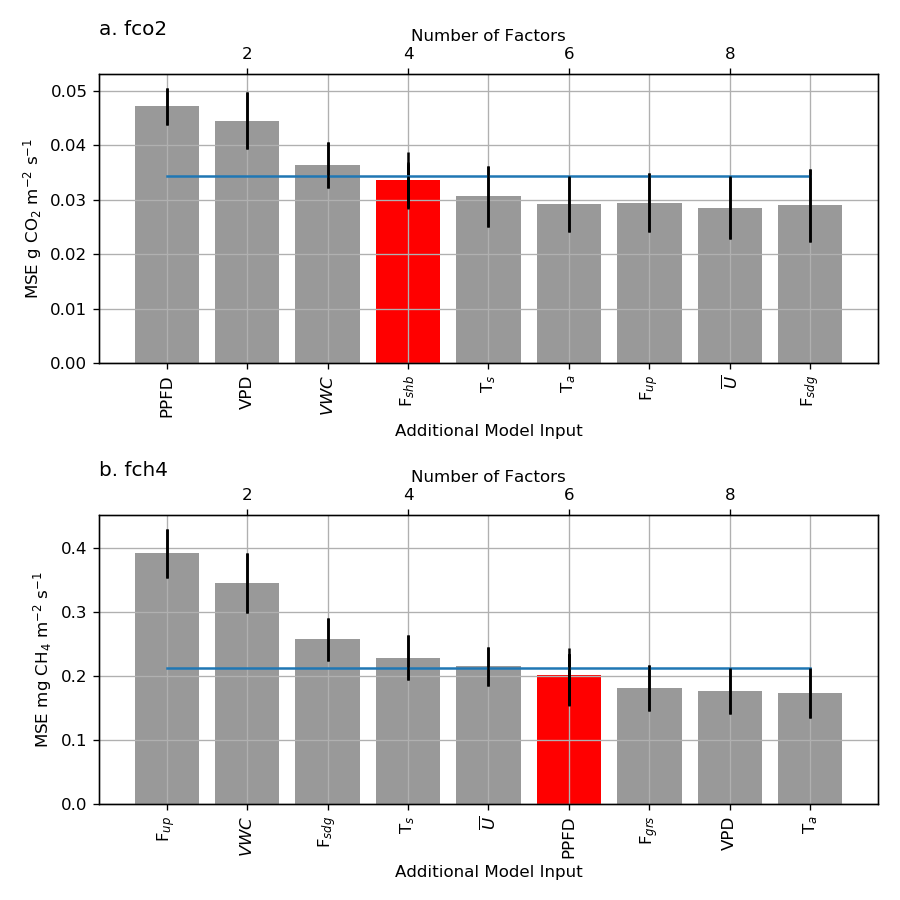

                          Model       MSE  Size  Number        SE  \
27  wind_speed+PPFD_Avg+VPD+VWC  0.032798     4       0  0.004125   
28   PPFD_Avg+AirTC_Avg+VPD+VWC  0.032275     4       1  0.003904   
31       PPFD_Avg+VPD+VWC+Shrub  0.031927     4       4  0.002488   
32       PPFD_Avg+VPD+VWC+Grass  0.033587     4       5  0.005156   
33      PPFD_Avg+VPD+VWC+Upland  0.033330     4       6  0.003238   

    Performance         T  T2 Model_Key      RMSE  
27            1  0.989995   0       4_0  0.181101  
28            1  0.411518   0       4_1  0.179652  
31            1  0.000000   0       4_4  0.178681  
32            1  1.588673   0       4_5  0.183269  
33            1  1.881661   0       4_6  0.182564  
                                         Model       MSE  Size  Number  \
40   wind_speed+PPFD_Avg+Temp+VWC+Sedge+Upland  0.193799     6       0   
41  wind_speed+AirTC_Avg+Temp+VWC+Sedge+Upland  0.199381     6       1   
42        wind_speed+VPD+Temp+VWC+Sedge+Upland  0.1

<IPython.core.display.Javascript object>


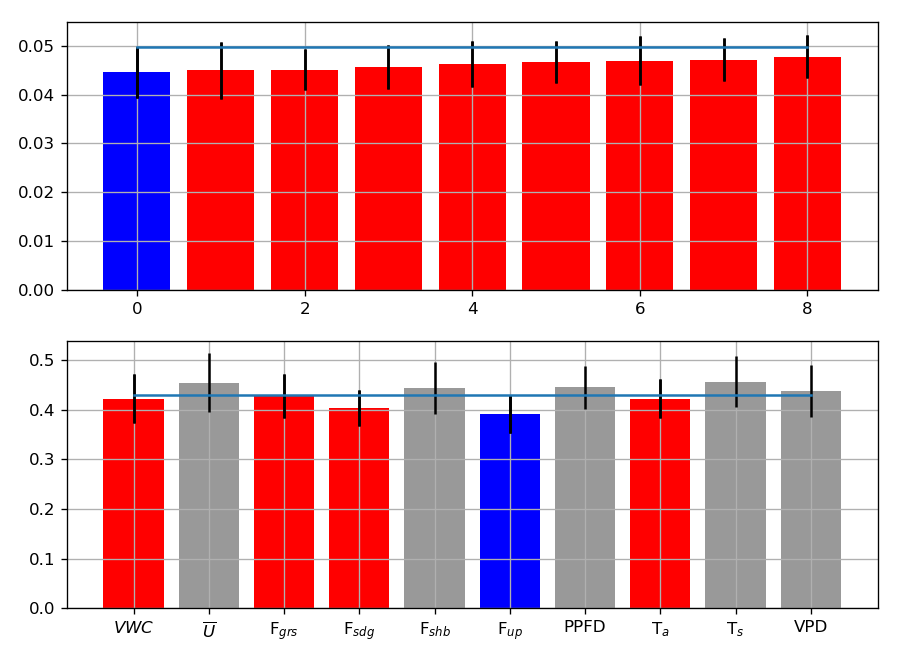


   index                Model       MSE  Size  Number        SE  Performance  \
0     12         PPFD_Avg+VPD  0.044569     2       2  0.005265            0   
1     14         PPFD_Avg+VWC  0.044985     2       4  0.005782            0   
2     10  wind_speed+PPFD_Avg  0.045127     2       0  0.004189            0   
3     16       PPFD_Avg+Shrub  0.045683     2       6  0.004459            0   
4     11   PPFD_Avg+AirTC_Avg  0.046324     2       1  0.004751            0   
5     15       PPFD_Avg+Sedge  0.046655     2       5  0.004347            0   
6     18      PPFD_Avg+Upland  0.046927     2       8  0.005043            0   
7     13        PPFD_Avg+Temp  0.047189     2       3  0.004377            0   
8     17       PPFD_Avg+Grass  0.047773     2       7  0.004446            0   

          T  T2 Model_Key      RMSE  
0  0.000000   0       2_2  0.211114  
1  0.291037   0       2_4  0.212096  
2  0.454205   0       2_0  0.212431  
3  0.884121   0       2_6  0.213735  
4  1.355

In [7]:

    
MP=False
Scope = 'Test'
cwd = os.getcwd()
# cwd = 'C:\\Users\\wesle\\Backup'
# Site='FishIsland'
Fill = False


fig,ax=plt.subplots(2,1,figsize=(7.5,7.5))
Performance(ax[0],'a. fco2',fco2)
Performance(ax[1],'b. fch4',fch4)
ax[0].set_ylabel('MSE g CO$_2$ m$^{-2}$ s$^{-1}$')
ax[1].set_ylabel('MSE mg CH$_4$ m$^{-2}$ s$^{-1}$')


plt.tight_layout()
plt.savefig('Fig6.png')


plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig6.png',dpi=300)


fig,ax=plt.subplots(2,1,figsize=(7.5,5.5))
LevelPerformance(ax[0],'a. fco2',fco2,level=2)
LevelPerformance(ax[1],'b. fch4',fch4,level=1)
plt.tight_layout()

In [6]:

Disp = Display([fco2,fch4],['fco2','fch4'])

A Jupyter Widget

Select Model for:  fco2


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

PPFD_Avg+AirTC_Avg
Select Model for:  fch4


A Jupyter Widget

A Jupyter Widget

VWC+Upland
PPFD_Avg+AirTC_Avg


A Jupyter Widget

A Jupyter Widget

PPFD_Avg+AirTC_Avg


<IPython.core.display.Javascript object>


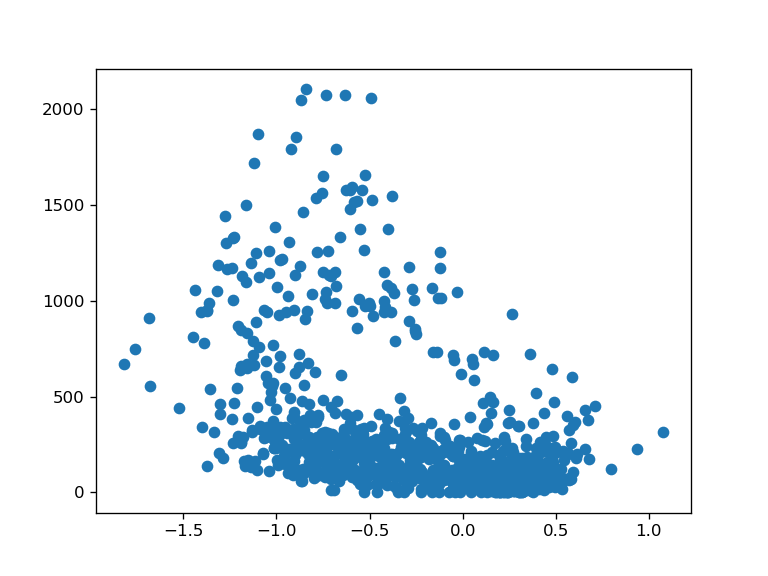

<IPython.core.display.Javascript object>


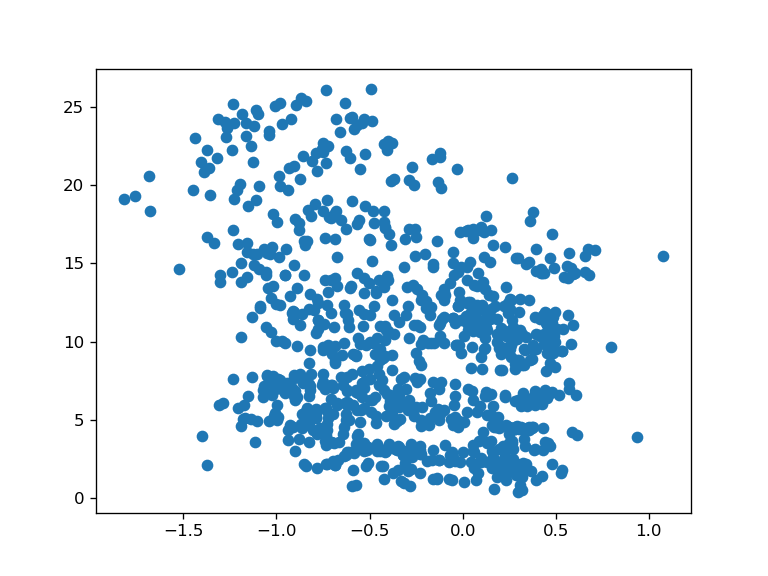

<IPython.core.display.Javascript object>


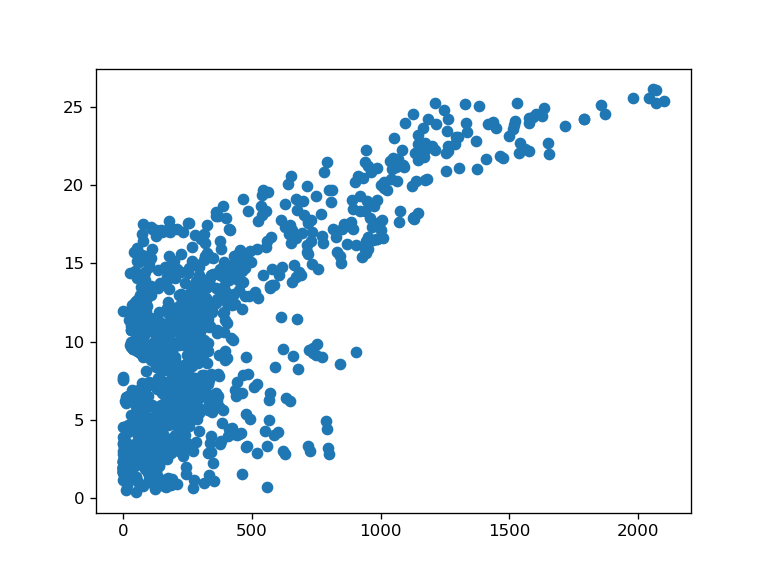

In [8]:
plt.figure()
plt.scatter(fco2.RST.Master['fco2'],fco2.RST.Master['VPD'])
plt.figure()
plt.scatter(fco2.RST.Master['fco2'],fco2.RST.Master['AirTC_Avg'])
plt.figure()
plt.scatter(fco2.RST.Master['VPD'],fco2.RST.Master['AirTC_Avg'])

In [9]:


import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

T30 = fco2.RST.Master.copy()
# T30['TA'] = T30['AirTC_Avg'].shift(-2)

# T30 = T30.loc[((T30.index>'2016-07-10 23:30:00') & (T30.index<'2016-08-07 00:00:00'))]
# T30['Rain_mm_Tot']=T30['Rain_mm_Tot'].fillna(0)*10
# T30[['Sedge','Shrub','Grass','Upland']]=T30[['Sedge','Shrub','Grass','Upland']].interpolate()
# forest = RandomForestRegressor(max_leaf_nodes= int(10),min_samples_leaf=30)
# Vars = ['TA','AirTC_Avg','NR_Wm2_Max','wind_speed','Rain_mm_Tot','VPD','DOY','DOY2','Temp','VWC']
# test = T30.loc[T30['DOY']<200,Vars].dropna()
# Key = Vars[0:5]
# forest=LinearRegression().fit(test[Key],test['Temp'])
# T30[Key]=T30[Key].ffill().bfill()
# T30['TempFIll'] = forest.predict(T30[Key])
# test = T30[['TempFIll','Temp','AirTC_Avg']].dropna()
# # print(metrics.r2_score(test['Temp'],test['TempFIll']))
# T30['Temp']=T30['Temp'].fillna(T30['TempFIll'])
# test = T30[Vars].dropna()
# Key=['DOY','DOY2','Temp','Rain_mm_Tot']
# forest = LinearRegression().fit(test[Key],test['VWC'])
# T30[Key]=T30[Key].ffill().bfill()
# T30['TempFIll'] = forest.predict(T30[Key])
# test = T30[['TempFIll','VWC',]].dropna()
# # print(metrics.r2_score(test['VWC'],test['TempFIll']))
# T30['VWC']=T30['VWC'].fillna(T30['TempFIll'])




In [10]:

T30_Dark = T30.copy()
T30_Dark['PPFD']=T30['PPFD'].min()

# T30_Fixed = T30.copy()
# T30_AntiFixed = T30.copy()
# FPRatios = {'Sedge':.122,
#             'Sparse':.085,
#             'Shrub':.602,
#             'Grass':.159,
#             'Upland':0.0,
#             'Out_of_Basin':0.0
# }

# FPRatios = {'Sedge':1,
#             'Sparse':0.0,
#             'Shrub':0.0,
#             'Grass':0.0,
#             'Upland':0.0,
#             'Out_of_Basin':0.0
# }


# for var in ['Sedge','Sparse','Shrub','Grass','Upland','Out_of_Basin']:
#     T30_Fixed[var] = FPRatios[var]
    
# T30_Dark_Fixed = T30_Fixed.copy()
# T30_Dark_Fixed['PPFD_Avg']=T30['PPFD_Avg'].min()

# T30 = Mapper(T30,PAR,'NEE_JustPPFD')#,T30_Fixed)
# print('NEE_JustPPFD')
# T30 = Mapper(T30,PAR,'ER_JustPPFD',T30_Dark)#fco2
# print('ER_est')
# T30 = Mapper(T30,Upland,'NME_JustUpland')#,T30_Fixed)
# print('NME_JustUpland')
# T30 = Mapper(T30,Sedge,'NME_JustSedge')#,T30_Fixed)
# print('NME_JustSedge')
# T30 = Mapper(T30,ER,'ER_fixed_est',T30_Dark_Fixed)#fco2
# print('ER_fixed_est')
T30 = Mapper(T30,fco2,'ER_est',T30_Dark)#fco2
print('ER_est')
# T30 = Mapper(T30,fco2,'NEE_fixed_est',T30_Fixed)#,T30_Fixed)
# print('NEE_fixed_est')
T30 = Mapper(T30,fco2,'NEE_est')#,T30_Fixed)
print('NEE_est')
# T30 = Mapper(T30,fch4,'NME_fixed_est',T30_Fixed)#,T30_Fixed)
# print('NME_Sedge_est')
T30 = Mapper(T30,fch4,'NME_est')#,T30_Fixed)
print('NME_est')



KeyError: 'PPFD'

In [40]:


T30['NEE'] = T30['fco2'].fillna(T30['NEE_est'])
# T30['NEE'] = T30['fco2'].fillna(T30['NEE_est'])
T30['NME'] = T30['fch4'].fillna(T30['NME_est'])

T30['GPP'] = T30['NEE']-T30['ER_est']
T30['GPP_est'] = T30['NEE_est']-T30['ER_est']
# T30['GPP_fixed_est'] = T30['NEE_fixed_est']-T30['ER_fixed_est']

#

<IPython.core.display.Javascript object>


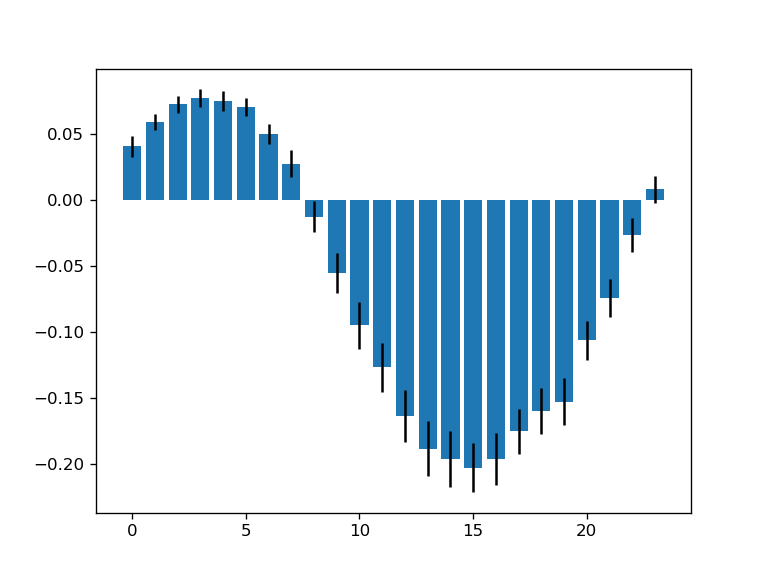

0.07665780739725435 0.006881723858301971
-0.20305690079265842 0.018576804270820323
(881, 26)
(343, 26)
0.3583418107833164
0.5457782299084435


In [43]:
Days = T30.groupby(T30.index.hour).mean()
DaysS = T30.groupby(T30.index.hour).std()
DaysC = T30.groupby(T30.index.hour).count()
Days['NEES']=DaysS['NEE']
Days['NEEC']=DaysC['NEE']


plt.figure()
plt.bar(Days.index,Days['NEE'],yerr=DaysS['NEE']/DaysC['NEE']**.5*stats.t.ppf(1-0.025,DaysC['NEE']))
# print(Days['NEE'].max(),Days['NEE'].min())
Max = (Days.loc[Days['NEE']==Days['NEE'].max(),['NEE','NEES','NEEC']])
Min = (Days.loc[Days['NEE']==Days['NEE'].min(),['NEE','NEES','NEEC']])
# print(T30['NEE'].max(),T30['NEE'].min())
print(Max['NEE'].values[0],(Max['NEES']/Max['NEEC']**.5*stats.t.ppf(1-0.025,Max['NEEC'])).values[0])
print(Min['NEE'].values[0],(Min['NEES']/Min['NEEC']**.5*stats.t.ppf(1-0.025,Min['NEEC'])).values[0])

Temp = fco2.RST.Master.loc[np.isnan(fco2.RST.Master['fco2'])==False]
print(Temp.loc[Temp['fco2']>0].shape)
print(Temp.loc[Temp['PPFD']<10].shape)

print(1-T30['fco2'].count()/T30['NEE'].count())
print(1-T30['fch4'].count()/T30['NME'].count())
# print(1-T30['fch4'].count()/T30['NME'].count())
# print(1-fco2.RST.Master['Sedge'].count()/fco2.RST.Master['Temp'].count())
# print(T30['NME'].count())

# plt.figure()
# plt.scatter(T30['fco2'],T30['NEE_JustPPFD'])
# Temp = T30[['fco2','NEE_JustPPFD']].dropna()
# print(metrics.r2_score(Temp['fco2'],Temp['NEE_JustPPFD']))
# print(metrics.mean_squared_error(Temp['fco2'],Temp['NEE_JustPPFD']))
# print(Temp[['fco2','NEE_JustPPFD']].mean())


# plt.figure()
# plt.scatter(T30['fch4'],T30['NME_JustUpland'])
# Temp = T30[['fch4','NME_JustUpland']].dropna()
# print(metrics.r2_score(Temp['fch4'],Temp['NME_JustUpland']))
# print(metrics.mean_squared_error(Temp['fch4'],Temp['NME_JustUpland']))
# print(Temp[['fch4','NME_JustUpland']].mean())

# plt.figure()
# plt.scatter(T30['fch4'],T30['NME_JustSedge'])
# Temp = T30[['fch4','NME_JustSedge']].dropna()
# print(metrics.r2_score(Temp['fch4'],Temp['NME_JustSedge']))
# print(metrics.mean_squared_error(Temp['fch4'],Temp['NME_JustSedge']))
# print(Temp[['fch4','NME_JustSedge']].mean())

In [45]:
# PooledVar_interval = Pooledstd_interval
mult = 24
Estimates = []
CIs = []
IntType = []
Scale = []
Samples = []
Fluxes = []
Type = []
# for Var in ['NEE','NEE_fixed_est','ER_est','ER_fixed_est','GPP_est','GPP_fixed_est','NME','NME_fixed_est']:#,
for Var in ['NEE','ER_est','GPP_est','NME']:#,
#             'NEE_JustPPFD','ER_JustPPFD']:
# Var = 'NEE'
    if Var == 'NEE' or Var == 'NME':
        CIPI = 'CI'
        Int=T30[Var].std()/(T30[Var].count()**.5) *stats.t.ppf(1-.025,T30[Var].count())*mult
        Type.append('EC Obs.')
        Fluxes.append(Var)
    elif Var[:3]=='GPP':
        Int=0
        Fluxes.append(Var.split('_')[0])
        Type.append('NN est.')
        
    else:
        
        Fluxes.append(Var.split('_')[0])
        CIPI = 'PI'
        Type.append('NN est.')
        pooled_std = PooledVar_interval(T30,
            [Var+'_Var_reg',Var+'_Var_er'],fco2,'NEE_est')
        Int=pooled_std*(1/T30.shape[0]+1/T30.shape[0])**.5*stats.t.ppf(1-.025,T30[Var].count())*mult
#     print(Var)
    U = T30[Var].mean()*mult
#     print('Mean: ',U)
    
#     print(CIPI+': ',Int)
#     print('Var: ',T30[Var].std()**2)

    Estimates.append(U)
    CIs.append(Int)
    if len(Var.split('_'))==3:
        Scale.append('Basin')
    elif len(Var.split('_'))>1:
        if Var.split('_')[1][0:3] == 'Jus':
            Scale.append(Var.split('_')[1][4:])
        else:
            Scale.append('Footprint')
    else:
        Scale.append('Footprint')
    
    Samples.append(T30[Var].count())
    IntType.append(CIPI)
           
Data = {'Flux':Fluxes,'Scale':Scale,'Estimates':Estimates,
        '95% CI/PI':CIs,'Interval Type':IntType,'N':Samples,
       'Type':Type}
Res = pd.DataFrame(data = Data)
# print(Res)
Cres = pd.read_csv('C:\\Users\\wesle\\Illisarvik_Processing/ScaledChamberFluxes.csv',
                   index_col=[0],delimiter = ',')
                   
# print(Cres)

All = Res.append(Cres).sort_values('Flux').reset_index(drop=True)
# Tem = (All.loc[All['Type'] == 'NN est.'])
# Tem = (All.loc[All['Type'] == 'NN est.'])
# CO2=(Tem.loc[Tem['Flux'] == 'NEE','Estimates']).values[0]
# CH4=(Tem.loc[Tem['Flux'] == 'NME','Estimates']*28*1e-3).values[0]

# print(CO2,CH4,CO2+CH4)

In [47]:
# fig,ax = plt.subplots(2,1,figsize = (6.5,7),sharex=True)


# ax1 = plt.subplot2grid((3, 1), (0, 0))
# ax2 = plt.subplot2grid((3, 1), (1, 0))#, rowspan=2)
# ax3 = plt.subplot2grid((3, 1), (2, 0))
print(All)
# Labels =['EC Obs.\nFootprint Scale','NN est.\nBasin Scale','Chamber\nFootprint Scale','Chamber\nBasin Scale']
# # ax1.bar([2,3],[0,0],All
# #         color='None')
# # ax1.bar([0,1],All.loc[All['Flux']=='GPP','Estimates']*-1,color='lightgreen',label = 'GPP')
# ax1.bar([0,1],All.loc[All['Flux']=='NEE','Estimates']*-1,
#         yerr = All.loc[All['Flux']=='NEE','95% CI/PI'],color='green',label='NEE')
# # ax1.bar([2,3],[0,0],
# #         color='None')

# ax2.bar([0,1,2,3],All.loc[All['Flux']=='ER','Estimates'],
#         yerr = All.loc[All['Flux']=='ER','95% CI/PI'],color='brown',label='ER')

# Conv = 28*1e-3
# ax3_2=ax3.twinx()
# ax3.bar([0,1,2,3],All.loc[All['Flux']=='NME','Estimates'],
#         yerr = All.loc[All['Flux']=='NME','95% CI/PI'],color='red',label='NME')
# ax3_2.bar([0,1,2,3],All.loc[All['Flux']=='NME','Estimates']*Conv,color='None',label='')
# ax3.set_xticks([0,1,2,3])
# ax1.set_xticks([0,1,2,3])
# yt = ax1.get_yticks()
# ax1.set_yticks(yt)
# ax1.set_yticklabels(yt*-1)
# ax2.set_xticks([0,1,2,3])
# ax3.set_xticklabels(Labels)
# ax1.set_xticklabels([])
# ax2.set_xticklabels([])
# # ax1.legend(loc=4)
# # ax2.legend(loc=2)
# ax1.grid()
# ax2.grid()
# ax1.set_title('a. NEE',loc='left')
# ax1.set_ylabel('g CO$_2$ m$^{-2}$ d$^{-1}$')
# ax2.set_title('b. ER',loc='left')
# ax2.set_ylabel('g CO$_2$ m$^{-2}$ d$^{-1}$')
# # ax3.legend(loc=2)
# ax3.grid()
# ax3.set_title('c. NME',loc='left')
# ax3.set_ylabel('mg CH$_4$ m$^{-2}$ d$^{-1}$')
# ax3_2.set_ylabel('g CO$_2$ eq. m$^{-2}$ d$^{-1}$')
# # ax3.bar([2,3],[0,0],
# #         color='None')
# plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig5.png')  

  Flux      Scale  Estimates  95% CI/PI Interval Type            N     Type
0   ER  Footprint   1.145931   0.167238            PI  3932.000000  NN est.
1   ER  Footprint  14.826690   3.618140            CI    74.920521  Chamber
2   ER      Basin  13.601409   3.846433            CI    56.365620  Chamber
3  GPP  Footprint  -2.614717   0.000000            PI  3932.000000  NN est.
4  NEE  Footprint  -1.454150   0.103736            CI  3932.000000  EC Obs.
5  NME  Footprint  45.483671   0.636540            CI  3932.000000  EC Obs.
6  NME  Footprint  17.086510  11.525820            CI    74.920521  Chamber
7  NME      Basin  19.406718  13.525331            CI    56.365620  Chamber


In [49]:
# fco2_final = fco2
# fch4_final = fch4

H1 = T30.resample('D').mean()
# H1['Rain_mm_Tot'] = T30['Rain_mm_Tot'].resample('D').sum()
H1s = T30.resample('D').std()
for v in ['ER_est_','ER_fixed_est_','NEE_est_','NEE_fixed_est_','NME_est_','NME_fixed_est_','NEE_JustPPFD_','ER_JustPPFD_']:
    H1[v+'Pooled_CI'] = 0
    for day in H1.index:
        Samp = T30.loc[(T30.index>=day)&(T30.index<day+datetime.timedelta(days=1))]
        pooled_std = PooledVar_interval(Samp,
                [v+'Var_reg',v+'Var_er'],fco2,v[:-1])**.5
#         print()
#         print(pooled_std)
#         print(Samp[[v+'Var_reg',v+'Var_er']].sum(axis=1).mean()**.5)
        H1.loc[H1.index==day,v+'Pooled_CI']=pooled_std/(Samp.shape[0]**.5)*stats.t.ppf(1-.025,Samp.shape[0])
        H1.loc[H1.index==day,v+'Pooled_PI']=pooled_std*((1/Samp.shape[0]+1/T30.shape[0])**.5)*stats.t.ppf(1-.025,Samp.shape[0])

# plt.figure()
# plt.plot(H1['ER_est_Pooled_CI'])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyError: "['ER_fixed_est_Var_reg' 'ER_fixed_est_Var_er'] not in index"

In [ ]:
mult = 24
print('Cbal', T30['NEE'].mean()*mult+T30['NME'].mean()*mult*1e-3*28)
print('Cbal', T30['NEE_fixed_est'].mean()*mult+T30['NME_fixed_est'].mean()*mult*1e-3*28)
# print(H1['NEE'].min()*24,H1['NEE'].max()*24)


<IPython.core.display.Javascript object>


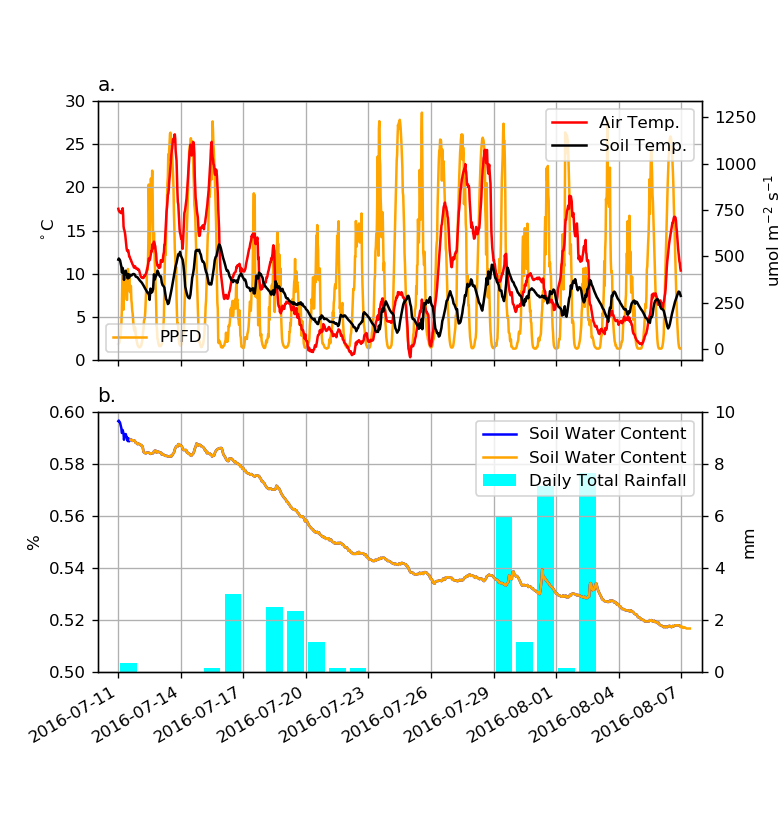

<IPython.core.display.Javascript object>


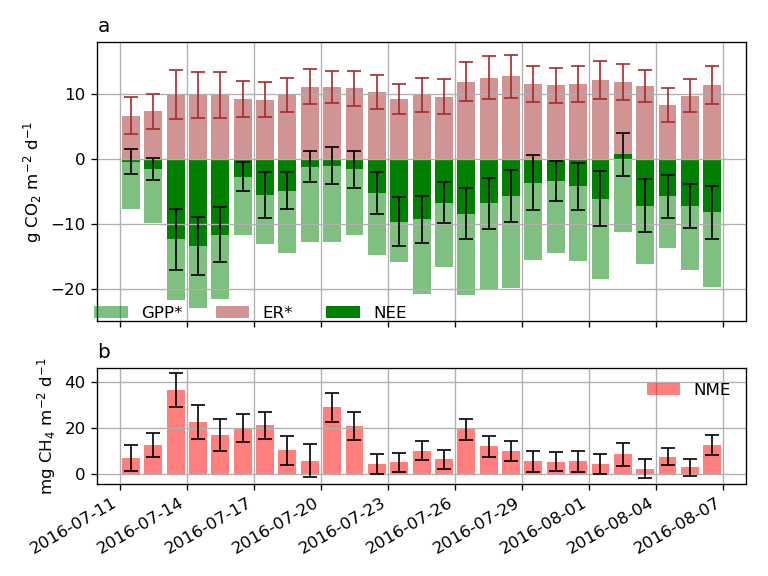

In [774]:
fig,ax = plt.subplots(2,1,figsize = (6.5,7),sharex=True)
ax[0].plot(T30['AirTC_Avg'],color='red',label = 'Air Temp.')
ax[0].plot(T30['Temp'],color='black',label = 'Soil Temp.')
ax[0].set_ylim(0,30)
yax2 = ax[0].twinx()
yax2.plot(T30['PPFD_Avg'],color='orange',label='PPFD')

ax[0].grid()
ax[0].set_zorder(ax[0].get_zorder()+1)
ax[0].patch.set_visible(False)

yax2.set_ylabel('umol m$^{-2}$ s$^{-1}$')
ax[0].set_ylabel('$^\circ$C')
ax[0].legend()
yax2.legend(loc=3)
ax[0].set_title('a.',loc='left')

yax2 = ax[1].twinx()
yax2.bar(H1.index+datetime.timedelta(hours=12),H1['Rain_mm_Tot'],color='cyan',label = 'Daily Total Rainfall')
yax2.set_ylim(0,10)

ax[1].plot(T30['VWC'],color='blue',label = 'Soil Water Content')
# ax[1].plot(fco2.RST.Master['VWC'],color='orange',label = 'Soil Water Content')
ax[1].bar(H1.index,H1['Rain_mm_Tot']*np.nan,color='cyan',label = 'Daily Total Rainfall')
ax[1].set_ylim(.50,.6)
ax[1].grid()
ax[1].set_zorder(ax[1].get_zorder()+1)
ax[1].patch.set_visible(False)
yax2.set_ylabel('mm')
ax[1].set_ylabel('%')
ax[1].legend()
ax[1].set_xlim([datetime.date(2016, 7, 10), datetime.date(2016, 8, 8)])
ax[1].set_title('b.',loc='left')
fig.autofmt_xdate()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig2.png',dpi=300)


fig = plt.figure()
ax0 = plt.subplot2grid((3, 3), (0, 0), rowspan=2,colspan=3)
ax1 = plt.subplot2grid((3, 3), (2, 0), rowspan=1,colspan=3)
ax=[ax0,ax1]

mult = 24
ax[0].bar(H1.index+datetime.timedelta(hours=12),H1['GPP_est']*mult,
          color='green',
          label='GPP*',
#           yerr = H1['ER_est_Pooled_CI'],#*mult,
#           error_kw=dict(ecolor='green', lw=1, capsize=4, capthick=1),
          alpha=.5)
ax[0].bar(H1.index+datetime.timedelta(hours=12),H1['ER_est']*mult,
          yerr = H1['ER_est_Pooled_PI']*mult,
          error_kw=dict(ecolor='brown', lw=1, capsize=4, capthick=1),
          color='brown',label='ER*',alpha=.5)
ax[0].bar(H1.index+datetime.timedelta(hours=12),H1['NEE']*mult,
#           yerr = H1['NEE_est_Pooled_CI']*mult,#/(48**.5)*stats.t.ppf(1-.025,48),#*mult,
          yerr = H1s['NEE']/(48**.5)*stats.t.ppf(1-.025,48)*mult,
          color='green',
          error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
          label='NEE')

ax[0].grid()
ax[0].set_title('a',loc='left')
ax[0].set_ylabel('g CO${_2} $ m$^{-2}$ d$^{-1}$')
ax[0].legend(bbox_to_anchor=(0, -.052, 0.5, .1),
             facecolor='None',
             edgecolor='None',
             ncol=3,loc=4)

ax[0].set_xticklabels([])
# ax[1].bar(H1.index+datetime.timedelta(hours=12),H1['NME_Sedge_est']*mult,
#           yerr = H1['NME_Sedge_est_Pooled_CI']*mult,
# #           yerr = H1s['NME']/(48**.5)*stats.t.ppf(1-.025,48)*mult,
#           color='green',
#           error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
#           alpha=.5,
#           label ='NME_Sedge_est')
ax[1].bar(H1.index+datetime.timedelta(hours=12),H1['NME']*mult,
          yerr = H1['NME_est_Pooled_CI']*mult,
#           yerr = H1s['NME']/(48**.5)*stats.t.ppf(1-.025,48)*mult,
          color='red',
          error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
          alpha=.5,
          label ='NME')
ax[1].grid()
ax[1].set_title('b',loc='left')
ax[1].set_ylabel('mg CH${_4} $ m$^{-2}$ d$^{-1}$')

ax[0].set_xlim([datetime.date(2016, 7, 10), datetime.date(2016, 8, 8)])
ax[1].set_xlim([datetime.date(2016, 7, 10), datetime.date(2016, 8, 8)])
ax[1].legend(facecolor='None',
         edgecolor='None',)
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig3.png',dpi=300)


<IPython.core.display.Javascript object>


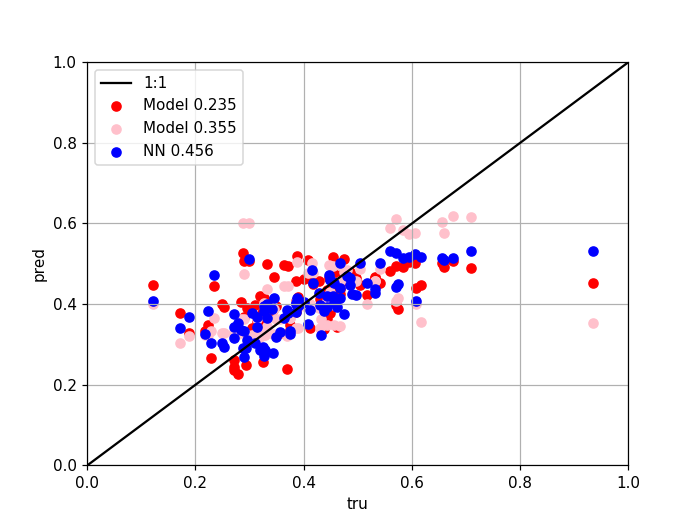

Mean ER:
ER         9.973933
ER_est    10.267147
ER2        9.156432
ER3       11.576413
dtype: float64

R2 Score:
ER_est:  0.4557464348084522 ER2:  0.23450566867643263 ER3:  0.3554159517869474

MSE:
ER_est:  0.10901320393509455 ER2:  0.12928539066242065 ER3:  0.11863647642630978
GPP_est   -17.439660
GPP2      -16.147904
GPP3      -18.388965
dtype: float64
NEE       -7.245154
NEE_est   -7.172514
NEE2      -6.991472
NEE3      -6.812552
dtype: float64
96 921 0.10423452768729642
(921, 283)
NEE_est:  0.8987568819824684 NEE2:  0.7849310905725322 NEE3:  0.7697469788072111
NEE_est:  0.16972270105605564 NEE2:  0.24736941116749978 NEE3:  0.2559527779801048


In [102]:

def P_func(PPFD,MQY,PM):
    cv =.7
    return((MQY*PPFD + PM - ((MQY*PPFD + PM)**2 - 4*cv*MQY*PPFD*PM)**.5)/(2*cv))
def R_func(T,r1,r2,r3):
    return(1/(r1*r2**T+r3))
def R_func2(T,Q10,R10):
    return(R10*Q10**((T-10)/10))
Dark = T30.loc[T30['PPFD_Avg']<10,['Temp','fco2','ER_est','AirTC_Avg']].dropna()


# print(T30.loc[T30['PPFD_Avg']<10,['Temp','fco2']].drop)
popt_r, pcov = curve_fit(R_func, Dark['Temp'], Dark['fco2'],p0=( 45.9262144,0.5875255,2.7508822))
popt_r2, pcov2 = curve_fit(R_func2, Dark['AirTC_Avg'], Dark['fco2'])#,p0=( 4.59262144,0.5875255,0.27508822))

#p0=( 74.59262144,0.8875255,2.27508822)
# print(metrics.r2_score(Dark['fco2'],R_func2(Dark['Temp'],*popt_r2)))

plt.figure()
plt.scatter(Dark['fco2'],R_func(Dark['Temp'],*popt_r),c='red',
            label='Model '+str(np.round(metrics.r2_score(Dark['fco2'],R_func(Dark['Temp'],*popt_r)),3)))
plt.scatter(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2),c='pink',
            label='Model '+str(np.round(metrics.r2_score(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2)),3))
           )
Dark['ER3'] = (R_func2(Dark['AirTC_Avg'],*popt_r2))
plt.scatter(Dark['fco2'],Dark['ER_est'],c='blue',
            label='NN '+str(np.round(metrics.r2_score(Dark['fco2'],Dark['ER_est']),3)))
# plt.colorbar()
plt.plot([0,1],[0,1],label='1:1',color='black')
plt.ylabel('pred')
plt.xlabel('tru')
plt.legend()

plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()
T30['ER2'] = R_func(T30['Temp'],*popt_r)
T30['ER3'] = R_func2(T30['AirTC_Avg'],*popt_r2)


P = T30[T30['PPFD_Avg']>=10]
P = P[['fco2','ER2','ER3','PPFD_Avg']].dropna()
popt_p, pcov = curve_fit(P_func, P['PPFD_Avg'], -1*(P['fco2']-P['ER2']),p0=(.01,10))
popt_p3, pcov3 = curve_fit(P_func, P['PPFD_Avg'], -1*(P['fco2']-P['ER3']),p0=(.01,10))
# T30['GPP2'] = Data['GPP'].fillna(P_func(Data['PPFD_Avg'],*popt_p))
T30['GPP2'] = -1*P_func(T30['PPFD_Avg'],*popt_p)
T30['GPP3'] = -1*P_func(T30['PPFD_Avg'],*popt_p3)
T30['NEE2'] = T30['GPP2']+T30['ER2']
T30['NEE3'] = T30['GPP3']+T30['ER3']

# popt_p, pcov = curve_fit(P_func, P['PPFD_Avg'], P['fco2']-,p0=(.003,12))
# Data['GPP'] = Data['GPP'].fillna(P_func(Data['PPFD_Avg'],*popt_p))
# Data['GPP_fill'] = P_func(Data['PPFD_Avg'],*popt_p)



# T30['GPP'] = T30['NEE']-T30['ER_est']
# T30['GPP2'] = T30['NEE_est']-T30['ER2']


Temp = T30.loc[np.isnan(T30['fco2'])==False]
print('Mean ER:')
print(Temp[['ER','ER_est','ER2','ER3']].mean()*mult)
# print(Dark['fco2'].mean())
print()
print('R2 Score:')
print('ER_est: ',metrics.r2_score(Dark['fco2'],Dark['ER_est']),
     'ER2: ',metrics.r2_score(Dark['fco2'],R_func(Dark['Temp'],*popt_r)),
     'ER3: ',metrics.r2_score(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2)))
print()
print('MSE:')
print('ER_est: ',metrics.mean_squared_error(Dark['fco2'],Dark['ER_est'])**.5,
     'ER2: ',metrics.mean_squared_error(Dark['fco2'],R_func(Dark['Temp'],*popt_r))**.5,
     'ER3: ',metrics.mean_squared_error(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2))**.5)
print(Temp[['GPP_est','GPP2','GPP3']].mean()*mult)
print(Temp[['NEE','NEE_est','NEE2','NEE3']].mean()*mult)
print(Temp['ER'].count(),T30['fco2'].count(),T30['ER'].count()/T30['fco2'].count())
print(Temp.shape)
TempNEE = Temp[['fco2','NEE','NEE_est','NEE2','NEE3']].dropna()
print('NEE_est: ',metrics.r2_score(TempNEE['fco2'],TempNEE['NEE_est']),
     'NEE2: ',metrics.r2_score(TempNEE['fco2'],TempNEE['NEE2']),
     'NEE3: ',metrics.r2_score(TempNEE['fco2'],TempNEE['NEE3']))
print('NEE_est: ',metrics.mean_squared_error(TempNEE['fco2'],TempNEE['NEE_est'])**.5,
     'NEE2: ',metrics.mean_squared_error(TempNEE['fco2'],TempNEE['NEE2'])**.5,
     'NEE3: ',metrics.mean_squared_error(TempNEE['fco2'],TempNEE['NEE3'])**.5)

<IPython.core.display.Javascript object>


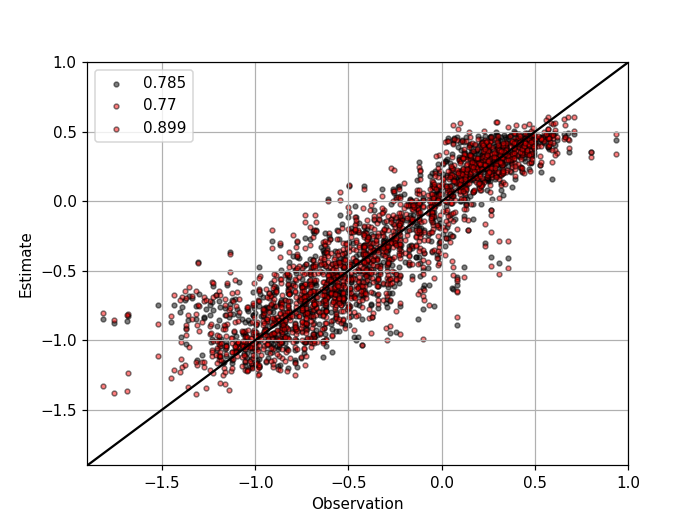

<IPython.core.display.Javascript object>


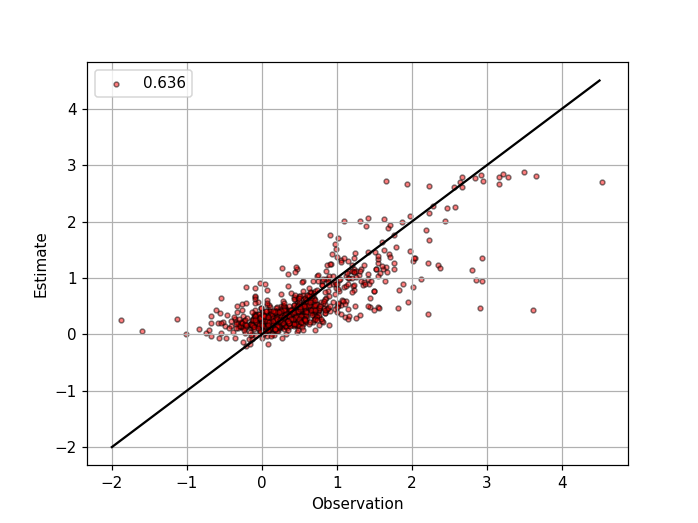

Text(0,0.5,'Estimate')

In [107]:
plt.figure()
# plt.scatter(T30['PPFD_Avg'],T30['fco2'],c='red',edgecolor='black',alpha=.5,s=10)
Temp=T30[['NEE2','NEE3','NEE_est','fco2']].dropna()
plt.plot([-1.9,1],[-1.9,1],color='black')
plt.scatter(T30['fco2'],T30['NEE2'],c='black',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE2']),3)))
plt.scatter(T30['fco2'],T30['NEE3'],c='red',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE3']),3)))
plt.scatter(T30['fco2'],T30['NEE_est'],c='red',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE_est']),3)))
plt.grid()
plt.legend()
plt.xlabel('Observation')
plt.ylabel('Estimate')
plt.ylim(-1.9,1)
plt.xlim(-1.9,1)

plt.figure()
# plt.scatter(T30['PPFD_Avg'],T30['fco2'],c='red',edgecolor='black',alpha=.5,s=10)
Temp=T30[['NME_est','fch4']].dropna()
plt.plot([-2,4.5],[-2,4.5],color='black')
# plt.scatter(T30['fco2'],T30['NEE2'],c='black',edgecolor='black',alpha=.5,s=10,
#            label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE2']),3)))
# plt.scatter(T30['fco2'],T30['NEE3'],c='red',edgecolor='black',alpha=.5,s=10,
#            label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE3']),3)))
plt.scatter(T30['fch4'],T30['NME_est'],c='red',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fch4'],Temp['NME_est']),3)))
plt.grid()
plt.legend()
plt.xlabel('Observation')
plt.ylabel('Estimate')
# plt.ylim(-1.9,1)
# plt.xlim(-1.9,1)



In [45]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def MapJobs(target,Range,N,Mask={},map_range=None):
    
    target.Project(Projector = None,Model = None)
    columns=[Range]
    l = 1
    for key in Mask.keys():
        columns.append(key)  
        l+=1
    for v in target.params['Inputs']:
        if v not in columns:
            columns.append(v)
    try:

        scaler = StandardScaler()
        scaler.fit(target.RST.Data[columns[l:]])
        Temp = scaler.transform(target.RST.Data[columns[l:]])
        Temp = pd.DataFrame(data = Temp,columns = columns[l:])
        kmeans = KMeans(n_clusters=N, random_state=0).fit(Temp)
#         print(kmeans)
#         print(Temp)
        Q = scaler.inverse_transform(kmeans.cluster_centers_)
    except:
        Q = []
        for col in columns[1:]:
            Q.append(Mask[col])
        Q=np.asanyarray(Q).T
        pass
    columns.append('target')
        
    def Make(Data,columns,map_range,values,C=20,Mask=None,i=0):
#         print(i)
        ranges = [np.linspace(map_range[0],map_range[1],C)]
#         print(ranges)
        for key in Mask.keys():
            ranges.append(np.ones(C)*Mask[key])
        for v in values:
            ranges.append(np.ones(C)*v)
        ranges.append(np.ones(C)*0)
        data = {}
        for (col,ran) in zip(columns,ranges):
            data[col]=ran
        data['key']=i
        
        return(pd.DataFrame(data = data))
    tarList=[]
    if map_range is None:
        map_range = [target.RST.Data[columns[0]].min(),target.RST.Data[columns[0]].max()]
    if len(Q) == 0:
        Data = Make(target.RST.Data,columns,
                    map_range=map_range,
                    values=[],Mask={key:item[i] for key, item in Mask.items()})
    for i,quantile in enumerate(Q):
        values = []
        for q in quantile:
            values.append(q)
#         print(Mask)
#         for key, item in Mask.items():
#             print(item)
#         for key,item in Mask.items():
#             print(key,item[0])
        if i == 0:
            Data = Make(target.RST.Data,columns,
                    map_range=map_range,#target.RST.Data[columns[0]].min(),1],#target.RST.Data[columns[0]].max()],
                    values=values,Mask={key:item[i] for key, item in Mask.items()})
        else:
            Data = Data.append(Make(target.RST.Data,columns,
                    map_range=map_range,#target.RST.Data[columns[0]].min(),1],#target.RST.Data[columns[0]].max()],
                    values=values,Mask={key:item[i] for key, item in Mask.items()},i=i))
            
    target.RST.Data=Data
#     print(target.RST.Data)
    target.RST.Scale(target.RST.params['target'],target.RST.params['Inputs'],ScalePath=target.RST.params['Spath'],Project=True)
    target.Map()
    tarList.append(target.Data_Map)  
    return(tarList,Q,columns[1:-1],Data)

# print([T30['VPD'].mean() for i in range(4)])
# N = 4
# tarList,means,columns=MapJobs(target,differential,N=N,
#                          Mask={'VPD':[T30['VPD'].mean() for i in range(4)],#
#                                'VWC':np.asanyarray([.6,.5,.6,.5]),
#                                'Shrub':np.asanyarray([0,0,1,1]),
#                                },
# #                          map_range=[0,1]
#                         )

In [381]:
def Plot(ax,Label,Data,regressor,color,target,Interval=None,linestyle='-',mult=1):
    Data = Data.sort_values(regressor)#.reset_index()
    try:
        Data['True']*=1
    except:
        Data['True']=0
        pass
    print(Data.loc[Data[regressor]==Data[regressor].min(),target])
    ax.plot(Data[regressor],Data[target]*mult,
            label= Label,
            linestyle=linestyle,
            linewidth=1.5,
            color = color)   
    if Interval != None:
        ax.fill_between(Data[regressor],
                    mult*(Data[target]-Data[Interval]), 
                    mult*(Data[target]+Data[Interval]),
                    alpha = .1,
                    color = color, 
                    linestyle='-',
                    linewidth=0,
                   )
        ax.plot(Data[regressor],
#                     mult*(Data[target]-Data[Interval]), 
                    mult*(Data[target]+Data[Interval]),
#                     alpha = .15,
                    color = color, 
                    linestyle=':',
                    linewidth=1,
                   )
        ax.plot(Data[regressor],
                    mult*(Data[target]-Data[Interval]), 
#                     mult*(Data[target]+Data[Interval]),
#                     alpha = .15,
                    color = color, 
                    linestyle=':',
                    linewidth=1,
                   )


In [68]:
line = '-'

A Jupyter Widget

(20, 1) (20,)


<IPython.core.display.Javascript object>


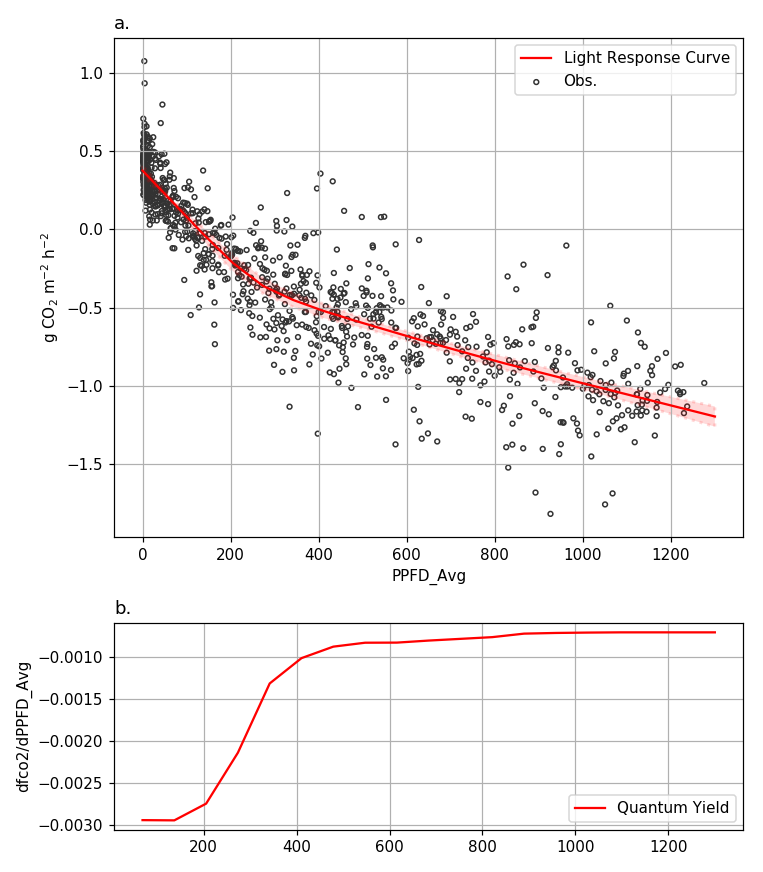

       fco2        PI
0  0.376638  0.352496
-0.002944828363565299 -0.0007074323067298301


In [97]:

colors = ['red']
N=len(colors)

Old = fco2.Model_Selection+''
# print(Old)
fco2.Model_Selection = 'PPFD_Avg'
map_range=[0,1300]
differential='PPFD_Avg'
tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(fco2,differential,N=N,
                         map_range=map_range
                        )
AllData=tarList_co2[0]
target = fco2
fig = plt.figure(figsize=(6.5,7))
# ,ax=plt.subplots(2,1,figsize=(7,10))

ax1 = plt.subplot2grid((3, 1), (0, 0),rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
# ax3 = plt.subplot2grid((4, 1), (3, 0))
# print(Data['key'].unique())
j = 0
# print(means_co2)
idx = []
ax = [ax1,ax2]
colorz = []
ax[0].scatter(target.RST.Master[differential],target.RST.Master['fco2']*1,
              edgecolor=[.2,.2,.2],
              facecolor='None',
              s=10,
              label = 'Obs.')

for key,color in zip(AllData['key'].unique(),colors):
#     List = [color]
#     List+=['white'for i in range(len(columns_co2))]
#     colorz.append(List)
    AllData['Select']=0
    
#     label = '# '+str(j)
#     idx.append(str(j))
    label = 'Light Response Curve'
    for i,col in enumerate(columns_co2):
        AllData.loc[np.abs(AllData[col]-means_co2[key,i])<1e-4,'Select']+=1
#         print(AllData['Select'].max())
    Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
    Plot(ax[0],label,
         Data,differential,color,target.target,Interval = 'CI',
         linestyle=line,mult=1)
    ax[0].set_xlabel(differential)
    ax[0].set_ylabel('g CO$_2$ m$^{-2}$ h$^{-1}$')
    tar = 'fco2'
    label = 'Quantum Yield'
    ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
           linestyle = line,
           label = label,
           color = color)
    ax[1].set_ylabel('d'+tar+'/d'+differential)
    j += 1
    print(np.min(Data[target.target].diff()/Data[differential].diff()),
          np.max(Data[target.target].diff()/Data[differential].diff()))
ax[0].legend(fontsize=10,loc=1)
ax[1].legend(fontsize=10,loc=4)

ax[0].grid()
ax[1].grid()
ax[0].set_title('a.',loc='left')
ax[1].set_title('b.',loc='left')


plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig7.png',dpi=300)

<IPython.core.display.Javascript object>


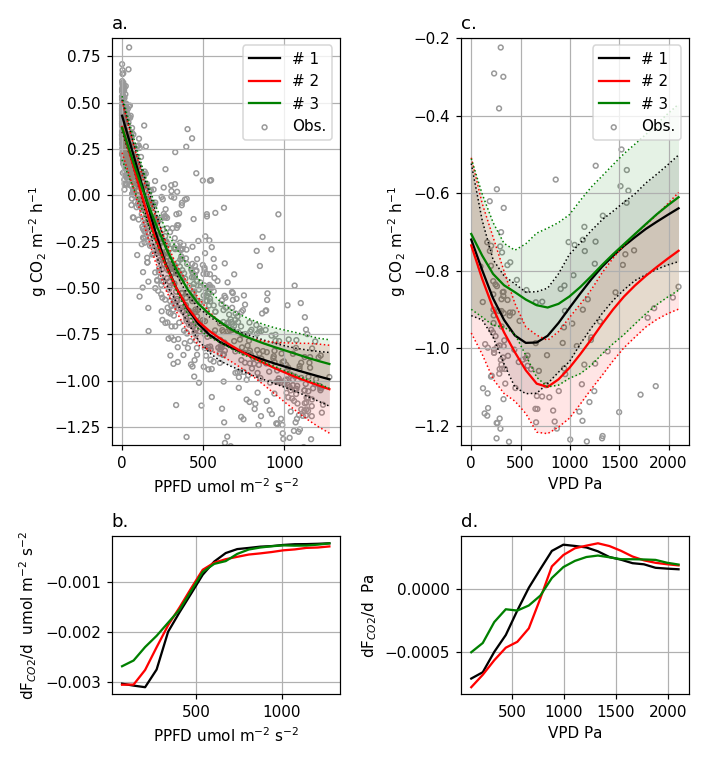

0    0.42979
Name: fco2, dtype: float32
-0.003097284616510525 -0.00023838508711796196
20    0.368985
Name: fco2, dtype: float32
-0.003047890349081978 -0.00030086447607790857
40    0.363748
Name: fco2, dtype: float32
-0.002680779056877676 -0.00024040344689503222
  Scenario     VPD  $VWC$  F$_{shb}$
1        1  326.72   0.55       0.38
2        2  326.72   0.55       0.10
3        3  326.72   0.55       0.80
0   -0.719779
Name: fco2, dtype: float32
-0.0007102055475530891 0.00034911763066474707
20   -0.734711
Name: fco2, dtype: float32
-0.0007787136516956818 0.000360220309594416
40   -0.705348
Name: fco2, dtype: float32
-0.0005019733303725284 0.00026319217537495196
  Scenario  $VWC$    PPFD  F$_{shb}$
1        1   0.55  1000.0       0.38
2        2   0.55  1000.0       0.10
3        3   0.55  1000.0       0.80


In [382]:
FirstRun=False
if FirstRun == True:  
    CO21 = []

fig = plt.figure(figsize=(6.5,7))

ax1 = plt.subplot2grid((3, 2), (0, 0),rowspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0))
ax3 = plt.subplot2grid((3, 2), (0, 1),rowspan=2)
ax4 = plt.subplot2grid((3, 2), (2, 1))

# differential='PPFD_Avg'
fco2.Model_Selection = 'PPFD_Avg+VPD'#+VWC+Shrub'
fco2.Model_Selection = 'PPFD_Avg+VPD+VWC+Shrub'
COLORS = [['black','red','green'],
#     ['black','blue','orange'],#+['red','orange','green','blue'],
          ['black','red','green']]
LINES = [['-','-','-'],#+[':',':',':',':'],
         ['-','-','-']]#]
Ns=[]
for colors in COLORS:
    Ns.append(len(colors))
N = 3
# map_range = [T30['PPFD_Avg'].min(),T30['PPFD_Avg'].max()]
Masks = [{'VPD':[T30['VPD'].mean() for n in range(N)],#
           'VWC':np.asanyarray([T30['VWC'].mean() for n in range(N)]),#+[.58,.52,.58,.52]),
           'Shrub':np.asanyarray([T30['Shrub'].mean(),.1,.8]),
           },
         {'VWC':[T30['VWC'].mean() for n in range(N)],#
           'PPFD_Avg':np.asanyarray([1000 for n in range(N)]),#+[.58,.52,.58,.52]),
           'Shrub':np.asanyarray([T30['Shrub'].mean(),.1,.8])
           },
        ]
differentials = ['PPFD_Avg','VPD']
map_ranges = [[T30[differentials[0]].min(),T30[differentials[0]].max()],
             [T30[differentials[1]].min(),T30[differentials[1]].max()]]
targets = [fco2,fco2]
k = 0
SCENARIOS = []
xlbs = [' umol m$^{-2}$ s$^{-2}$',' Pa']
for Mask,map_range,differential,N,colors,lines,target,xlb in zip(Masks,
    map_ranges,differentials,Ns,COLORS,LINES,targets,xlbs):
    if FirstRun == True:
        tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(target,differential,N=N,
             Mask=Mask,
                                 map_range=map_range
                                )
        CO21.append([tarList_co2,means_co2,columns_co2,Data_co2])
    else:
        tarList_co2,means_co2,columns_co2,Data_co2 = CO21[k]
    AllData=tarList_co2[0]
    j = 1
    idx = []
    if k == 0:
        ax = [ax1,ax2]#,ax3]
    else:
        ax = [ax3,ax4]
    colorz = []
    if target == ER:
        val = 'ER'
    else:
        val = 'fco2'
    if k == 1:
        Temp = target.RST.Master.loc[target.RST.Master['PPFD_Avg']>750,[differential,val,'PPFD_Avg']]
        Temp = Temp.loc[Temp['PPFD_Avg']<1250,[differential,val]]
        ax[0].scatter(Temp[differential],Temp[val]*1,
                      edgecolor=[.6,.6,.6],
                      facecolor='None',s=10,label = 'Obs.')
    else:
        ax[0].scatter(target.RST.Master[differential],target.RST.Master[val]*1,
                  edgecolor=[.6,.6,.6],
                  facecolor='None',s=10,label = 'Obs.')

    for key,color,line in zip(AllData['key'].unique(),colors,lines):
        List = [color]
        List+=['white'for i in range(len(columns_co2))]
        colorz.append(List)
        AllData['Select']=0

        label = '# '+str(j)
        idx.append(str(j))
        for i,col in enumerate(columns_co2):
            AllData.loc[np.abs(AllData[col]-means_co2[key,i])<1e-4,'Select']+=1
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        if target == PAR:
            Interval = 'CI'
        else:
            Interval = 'CI'#None
        Plot(ax[0],label,
             Data,differential,color,target.target,Interval = Interval,
             linestyle=line,mult=1)
        tar = 'F$_{CO2}$'

        ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
               linestyle = line,
               label = label,
               color = color)
        j += 1

        print(np.min(Data[target.target].diff()/Data[differential].diff()),
              np.max(Data[target.target].diff()/Data[differential].diff()))

    ax[0].set_xlabel(aliases[differential]+xlb)
    ax[0].set_ylabel('g CO$_2$ m$^{-2}$ h$^{-1}$')
    ax[1].set_ylabel('d'+tar+'/d '+xlb)
    ax[1].set_xlabel(aliases[differential]+xlb)
    ax[0].legend(fontsize=10,loc=1)

    ax[0].grid()
    ax[1].grid()
    if k == 0:
        ax[0].set_ylim([-1.35,.85])
    else:# val == 'ER':
        ax[0].set_ylim([-1.25,-.2])
        
        
    if k == 0:
        ax[0].set_title('a.',loc='left')
        ax[1].set_title('b.',loc='left')
    else:
        ax[0].set_title('c.',loc='left')
        ax[1].set_title('d.',loc='left')
        
    k+=1
    if target != PAR:
        cols = [aliases[col] for col in columns_co2]
        Scenarios = pd.DataFrame(data=means_co2,index=idx,columns=cols)
        Scenarios = Scenarios.round(2)
        Scenarios['Scenario']=idx
        Scenarios = Scenarios[['Scenario']+cols]
        print(Scenarios)
    SCENARIOS.append(Scenarios)

plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig7.png',dpi=300)
   

<IPython.core.display.Javascript object>


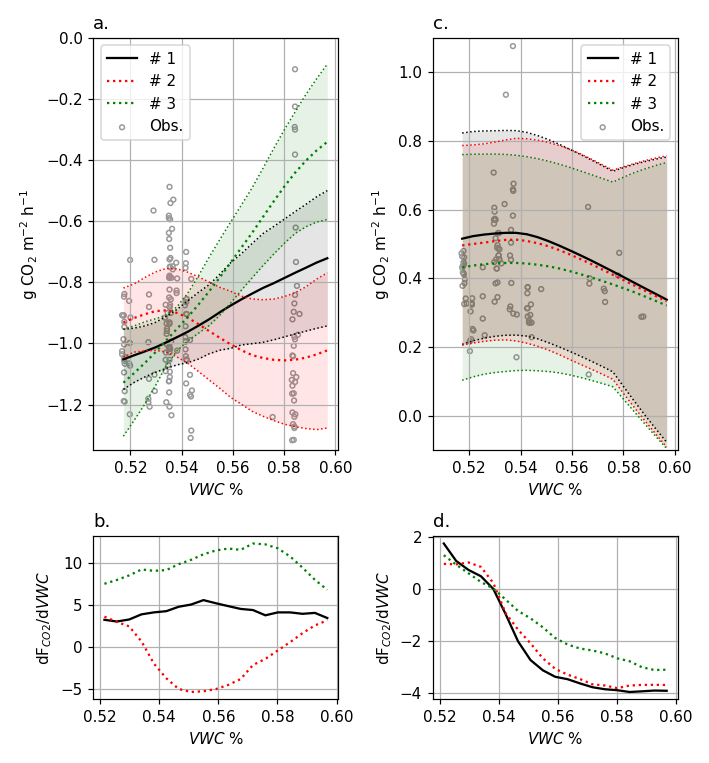

0   -1.052263
Name: fco2, dtype: float32
2.9960013914453447 5.544373798701335
20   -0.931736
Name: fco2, dtype: float32
-5.401039765656831 3.570660607004734
40   -1.128641
Name: fco2, dtype: float32
6.764754611463446 12.286436818828896
  Scenario     VPD    PPFD  F$_{shb}$
1        1  326.72  1000.0       0.38
2        2  326.72  1000.0       0.10
3        3  326.72  1000.0       0.80
0    0.51583
Name: fco2, dtype: float32
-3.948201738708428 1.746953772074361
20    0.49629
Name: fco2, dtype: float32
-3.800073306742385 1.0199407937484875
40    0.432183
Name: fco2, dtype: float32
-3.105404737759105 1.3001285966062968
  Scenario  PPFD     VPD  F$_{shb}$
1        1  1.76  326.72       0.38
2        2  1.76  326.72       0.10
3        3  1.76  326.72       0.80


In [396]:
FirstRun=False
if FirstRun == True:  
    CO22 = []

fig = plt.figure(figsize=(6.5,7))

ax1 = plt.subplot2grid((3, 2), (0, 0),rowspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0))
ax3 = plt.subplot2grid((3, 2), (0, 1),rowspan=2)
ax4 = plt.subplot2grid((3, 2), (2, 1))

# differential='PPFD_Avg'
fco2.Model_Selection = 'PPFD_Avg+VPD'#+VWC+Shrub'
fco2.Model_Selection = 'PPFD_Avg+VPD+VWC+Shrub'
COLORS = [['black','red','green'],#+['red','orange','green','blue'],
          ['black','red','green']]
LINES = [['-',':',':'],#+[':',':',':',':'],
         ['-',':',':']]#]
# colors = ['red','red','green','green','blue','blue']
# colors = ['red','orange','green','blue']#,'indigo','violet']
# lines = ['-',':','-',':','-',':']
Ns=[]
for colors in COLORS:
    Ns.append(len(colors))
N = 3
# map_range = [T30['PPFD_Avg'].min(),T30['PPFD_Avg'].max()]
Masks = [{'VPD':np.asanyarray([T30['VPD'].mean() for n in range(N)]),#
           'PPFD_Avg':np.asanyarray([1000 for n in range(N)]),#+[.58,.52,.58,.52]),
           'Shrub':[T30['Shrub'].mean(),.1,.8],
           },
         {'PPFD_Avg':np.asanyarray([T30['PPFD_Avg'].min() for n in range(N)]),#
           'VPD':np.asanyarray([T30['VPD'].mean() for n in range(N)]),#+[.58,.52,.58,.52]),
           'Shrub':np.asanyarray([T30['Shrub'].mean(),.1,.8]),
           },
        ]
differentials = ['VWC','VWC']
map_ranges = [[T30[differentials[0]].min(),T30[differentials[0]].max()],
             [T30[differentials[1]].min(),T30[differentials[1]].max()]]
targets = [fco2,ER]
k = 0
SCENARIOS = []
xlbs = [' %',' %']
for Mask,map_range,differential,N,colors,lines,target,xlb in zip(Masks,
    map_ranges,differentials,Ns,COLORS,LINES,targets,xlbs):
    if FirstRun == True:
        tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(target,differential,N=N,
             Mask=Mask,
                                 map_range=map_range
                                )
        CO22.append([tarList_co2,means_co2,columns_co2,Data_co2])
    else:
        tarList_co2,means_co2,columns_co2,Data_co2 = CO22[k]
    AllData=tarList_co2[0]
#     target = fco2
    j = 1
#     print(means_co2)
    idx = []
    if k == 0:
        ax = [ax1,ax2]#,ax3]
    else:
        ax = [ax3,ax4]
    colorz = []
    if target == ER:
        val = 'ER'
        ax[0].scatter(target.RST.Master[differential],target.RST.Master[val]*1,
                      edgecolor=[.6,.6,.6],
                      facecolor='None',s=10,label = 'Obs.')
    else:
        val = 'fco2'
        Temp = target.RST.Master.loc[target.RST.Master['PPFD_Avg']>750,[differential,val,'PPFD_Avg']]
        Temp = Temp.loc[Temp['PPFD_Avg']<1250,[differential,val]]
        ax[0].scatter(Temp[differential],Temp[val]*1,
                      edgecolor=[.6,.6,.6],
                      facecolor='None',s=10,label = 'Obs.')


    for key,color,line in zip(AllData['key'].unique(),colors,lines):
        List = [color]
        List+=['white'for i in range(len(columns_co2))]
        colorz.append(List)
        AllData['Select']=0

        label = '# '+str(j)
        idx.append(str(j))
        for i,col in enumerate(columns_co2):
            AllData.loc[np.abs(AllData[col]-means_co2[key,i])<1e-4,'Select']+=1
    #     print(AllData)
    #     print()
        intt = 'CI'
        if k == 1:
            intt='PI'
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        Plot(ax[0],label,
             Data,differential,color,target.target,Interval = intt,
             linestyle=line,mult=1)
        tar = 'F$_{CO2}$'

        ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
               linestyle = line,
               label = label,
               color = color)
        j += 1

        print(np.min(Data[target.target].diff()/Data[differential].diff()),
              np.max(Data[target.target].diff()/Data[differential].diff()))
    cols = [aliases[col] for col in columns_co2]
    Scenarios = pd.DataFrame(data=means_co2,index=idx,columns=cols)
    # Scenarios['VPD'] = T30['VPD'].mean()
    Scenarios = Scenarios.round(2)
    # Scenarios['VPD'] = Scenarios['VPD'].astype(int)
    Scenarios['Scenario']=idx
    Scenarios = Scenarios[['Scenario']+cols]

    ax[0].set_xlabel(aliases[differential]+xlb)
    ax[0].set_ylabel('g CO$_2$ m$^{-2}$ h$^{-1}$')
    ax[1].set_ylabel('d'+tar+'/d'+aliases[differential])
    ax[1].set_xlabel(aliases[differential]+xlb)
    if k == 0:
        loc = 2
    else:
        loc = 1
    ax[0].legend(fontsize=10,loc=loc)

    ax[0].grid()
    ax[1].grid()
    if val == 'fco2':
        ax[0].set_title('a.',loc='left')
        ax[1].set_title('b.',loc='left')
    else:
        ax[0].set_title('c.',loc='left')
        ax[1].set_title('d.',loc='left')
        
        
    if k == 0:
        ax[0].set_ylim([-1.35,0])
    else:# val == 'ER':
        ax[0].set_ylim([-.1,1.1])
        
        
    k+=1
    
    print(Scenarios)
      

    SCENARIOS.append(Scenarios)

plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig8.png',dpi=300)
   


In [328]:
print(T30['Sedge'].max())

0.55586267


<IPython.core.display.Javascript object>


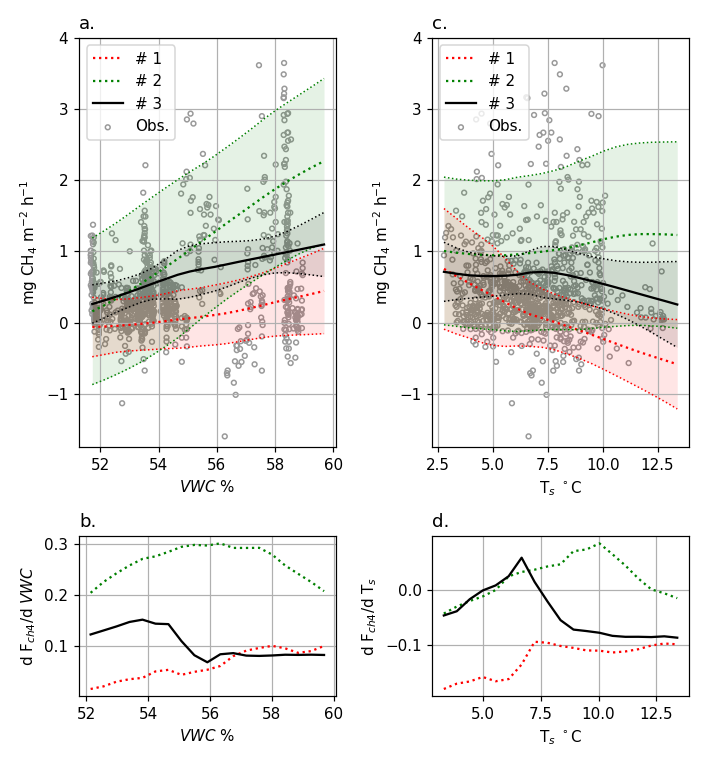

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0   -0.062248
Name: fch4, dtype: float32
0.017257773246116964 0.10119585463449979
20    0.159281
Name: fch4, dtype: float32
0.20442438503141452 0.30060027636766096
40    0.260869
Name: fch4, dtype: float32
0.06922173080509145 0.15216333834637943
  Scenario    PPFD  $\overline{U}$  T$_{s}$  F$_{up}$  F$_{sdg}$
1        1  333.28             3.0     7.29      0.15       0.00
2        2  333.28             3.0     7.29      0.00       0.55
3        3  333.28             3.0     7.29      0.06       0.11
0    0.754968
Name: fch4, dtype: float32
-0.180101381213716 -0.09459829219007614
20    1.006556
Name: fch4, dtype: float32
-0.04357047454614648 0.083520263713448
40    0.713613
Name: fch4, dtype: float32
-0.0872578792489593 0.057579537210317513
  Scenario    PPFD  $\overline{U}$  $VWC$  F$_{up}$  F$_{sdg}$
1        1  333.28             3.0   0.55      0.15       0.00
2        2  333.28             3.0   0.55      0.00       0.55
3        3  333.28             3.0   0.55      0.06       0.

In [384]:
FirstRun=False
if FirstRun == True:  
    CH41 = []

fig = plt.figure(figsize=(6.5,7))

ax1 = plt.subplot2grid((3, 2), (0, 0),rowspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0))
ax3 = plt.subplot2grid((3, 2), (0, 1),rowspan=2)
ax4 = plt.subplot2grid((3, 2), (2, 1))

COLORS = [['red','green','black'],#+['red','orange','green','blue'],
          ['red','green','black']]
# 'red','green',
# 'red','green',

LINES = [[':',':','-'],#,'-','-'],#+[':',':',':',':'],
         [':',':','-']]#,'-','-']]
Ns=[]
for colors in COLORS:
    Ns.append(len(colors))
N = 3
# map_range = [T30['PPFD_Avg'].min(),T30['PPFD_Avg'].max()]
Masks = [{'PPFD_Avg':[T30['PPFD_Avg'].mean() for i in range(N)],
      'wind_speed':[T30['wind_speed'].mean() for i in range(N)],
      'Temp':[T30['Temp'].mean() for i in range(N)],
      'Upland':[.15,0,T30['Upland'].mean()],
      'Sedge':[0,.55,T30['Sedge'].mean()],
     },
         {'PPFD_Avg':[T30['PPFD_Avg'].mean() for i in range(N)],
      'wind_speed':[T30['wind_speed'].mean() for i in range(N)],
      'VWC':[T30['VWC'].mean() for i in range(N)],
      'Upland':[.15,0,T30['Upland'].mean()],
      'Sedge':[0,.55,T30['Sedge'].mean()],
     }
        ]
differentials = ['VWC','Temp']
map_ranges = [[T30[differentials[0]].min(),T30[differentials[0]].max()],
             [T30[differentials[1]].min(),T30[differentials[1]].max()]]
targets = [fch4,fch4]
k = 0
SCENARIOS = []
xlbs = [' %',' $^\circ$C']
for Mask,map_range,differential,N,colors,lines,target,xlb in zip(Masks,
map_ranges,differentials,Ns,COLORS,LINES,targets,xlbs):
    if FirstRun == True:
        tarList_ch4,means_ch4,columns_ch4,Data_ch4=MapJobs(target,differential,N=N,
             Mask=Mask,
                                 map_range=map_range
                                )
        CH41.append([tarList_ch4,means_ch4,columns_ch4,Data_ch4])
    else:
        tarList_ch4,means_ch4,columns_ch4,Data_ch4 = CH41[k]
    AllData=tarList_ch4[0]
#     target = fch4
    j = 1
#     print(means_ch4)
    idx = []
    if k == 0:
        ax = [ax1,ax2]#,ax3]
    else:
        ax = [ax3,ax4]
    colorz = []
    if target == fch4:
        val = 'fch4'
    else:
        val = 'fch4'
    if differential == 'VWC':
        conv = 100
    else:
        conv = 1
    ax[0].scatter(target.RST.Master[differential]*conv,target.RST.Master[val],
                  edgecolor=[.6,.6,.6],
                  facecolor='None',s=10,label = 'Obs.')

    for key,color,line in zip(AllData['key'].unique(),colors,lines):
        List = [color]
        List+=['white'for i in range(len(columns_ch4))]
        colorz.append(List)
        AllData['Select']=0

        label = '# '+str(j)
        idx.append(str(j))
        for i,col in enumerate(columns_ch4):
            AllData.loc[np.abs(AllData[col]-means_ch4[key,i])<1e-4,'Select']+=1
    #     print(AllData)
    #     print()
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        if differential=='VWC':
            Data[differential]*=100
        Plot(ax[0],label,
             Data,differential,color,target.target,Interval = 'CI',
             linestyle=line,mult=1)
        tar = 'F$_{ch4}$'

        ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
               linestyle = line,
               label = label,
               color = color)
        j += 1

        print(np.min(Data[target.target].diff()/Data[differential].diff()),
              np.max(Data[target.target].diff()/Data[differential].diff()))
    cols = [aliases[col] for col in columns_ch4]
    Scenarios = pd.DataFrame(data=means_ch4,index=idx,columns=cols)
    # Scenarios['VPD'] = T30['VPD'].mean()
    Scenarios = Scenarios.round(2)
    # Scenarios['VPD'] = Scenarios['VPD'].astype(int)
    Scenarios['Scenario']=idx
    Scenarios = Scenarios[['Scenario']+cols]

    ax[0].set_xlabel(aliases[differential]+xlb)
    ax[0].set_ylabel('mg CH$_4$ m$^{-2}$ h$^{-1}$')
    ax[1].set_ylabel('d '+tar+'/d '+aliases[differential])
    ax[1].set_xlabel(aliases[differential]+xlb)
    ax[0].legend(fontsize=10,loc=2)

    ax[0].grid()
    ax[1].grid()
#     if val == 'fch4':
    ax[0].set_ylim([-1.75,4])
#     elif val == 'fch4':
#         ax[0].set_ylim([0,1.2])
        
#     ax[0].set_xlim([T30[differential].min()-T30[differential].min()*.01,T30[differential].max()+T30[differential].max()*.01])

    if k == 0:
        ax[0].set_title('a.',loc='left')
        ax[1].set_title('b.',loc='left')
    else:
        ax[0].set_title('c.',loc='left')
        ax[1].set_title('d.',loc='left')
        
    k+=1
    
    print(Scenarios)
      

    SCENARIOS.append(Scenarios)

plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig9.png',dpi=300)

<IPython.core.display.Javascript object>


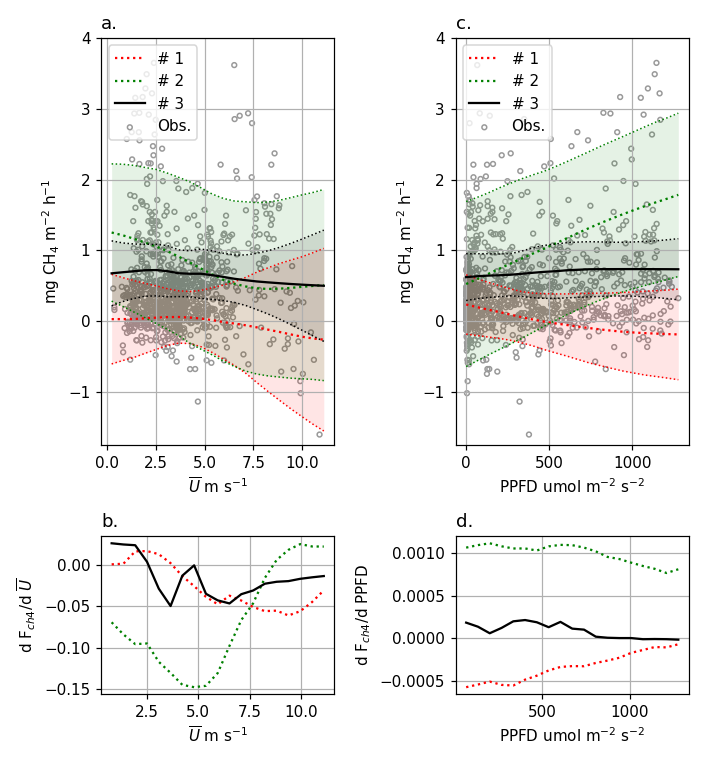

0    0.030502
Name: fch4, dtype: float32
-0.06103033804536498 0.017207949766667806
20    1.253299
Name: fch4, dtype: float32
-0.14812762542103058 0.025659658118608326
40    0.677184
Name: fch4, dtype: float32
-0.04954839451044025 0.026662141157134434
  Scenario    PPFD  $VWC$  T$_{s}$  F$_{up}$  F$_{sdg}$
1        1  333.28   0.55     7.29      0.15       0.00
2        2  333.28   0.55     7.29      0.00       0.55
3        3  333.28   0.55     7.29      0.06       0.11
0    0.237443
Name: fch4, dtype: float32
-0.0005678172195121443 -6.738530968624685e-05
20    0.526207
Name: fch4, dtype: float32
0.0007631675166937729 0.0011096170616073113
40    0.623677
Name: fch4, dtype: float32
-1.4016535466391441e-05 0.00021495131686608535
  Scenario  T$_{s}$  $\overline{U}$  $VWC$  F$_{up}$  F$_{sdg}$
1        1     7.29            3.88   0.55      0.15       0.00
2        2     7.29            3.88   0.55      0.00       0.55
3        3     7.29            3.88   0.55      0.06       0.11


In [385]:
FirstRun=False
if FirstRun == True:  
    CH42 = []

fig = plt.figure(figsize=(6.5,7))

ax1 = plt.subplot2grid((3, 2), (0, 0),rowspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0))
ax3 = plt.subplot2grid((3, 2), (0, 1),rowspan=2)
ax4 = plt.subplot2grid((3, 2), (2, 1))

COLORS = [['red','green','black'],#+['red','orange','green','blue'],
          ['red','green','black']]
# 'red','green',
# 'red','green',

LINES = [[':',':','-'],#,'-','-'],#+[':',':',':',':'],
         [':',':','-']]#,'-','-']]
Ns=[]
for colors in COLORS:
    Ns.append(len(colors))
N = 3
Masks = [{'PPFD_Avg':[T30['PPFD_Avg'].mean() for i in range(N)],
      'VWC':[T30['VWC'].mean() for i in range(N)],
      'Temp':[T30['Temp'].mean() for i in range(N)],
      'Upland':[.15,0,T30['Upland'].mean()],
      'Sedge':[0,.55,T30['Sedge'].mean()],
     },
         {'Temp':[T30['Temp'].mean() for i in range(N)],
      'wind_speed':[T30['wind_speed'].mean() for i in range(N)],
      'VWC':[T30['VWC'].mean() for i in range(N)],
      'Upland':[.15,0,T30['Upland'].mean()],
      'Sedge':[0,.55,T30['Sedge'].mean()],
     }
        ]
differentials = ['wind_speed','PPFD_Avg']
map_ranges = [[T30[differentials[0]].min(),T30[differentials[0]].max()],
             [T30[differentials[1]].min(),T30[differentials[1]].max()]]
targets = [fch4,fch4]
k = 0
SCENARIOS = []
xlbs = [' m s$^{-1}$',' umol m$^{-2}$ s$^{-2}$']
for Mask,map_range,differential,N,colors,lines,target,xlb in zip(Masks,
map_ranges,differentials,Ns,COLORS,LINES,targets,xlbs):
    if FirstRun == True:
        tarList_ch4,means_ch4,columns_ch4,Data_ch4=MapJobs(target,differential,N=N,
             Mask=Mask,
                                 map_range=map_range
                                )
        CH42.append([tarList_ch4,means_ch4,columns_ch4,Data_ch4])
    else:
        tarList_ch4,means_ch4,columns_ch4,Data_ch4 = CH42[k]
    AllData=tarList_ch4[0]
#     target = fch4
    j = 1
#     print(means_ch4)
    idx = []
    if k == 0:
        ax = [ax1,ax2]#,ax3]
    else:
        ax = [ax3,ax4]
    colorz = []
    if target == fch4:
        val = 'fch4'
    else:
        val = 'fch4'
    if differential=='VWC':
        m = 100
    else:
        m = 1
    ax[0].scatter(target.RST.Master[differential]*m,target.RST.Master[val]*1,
                  edgecolor=[.6,.6,.6],
                  facecolor='None',s=10,label = 'Obs.')

    for key,color,line in zip(AllData['key'].unique(),colors,lines):
        List = [color]
        List+=['white'for i in range(len(columns_ch4))]
        colorz.append(List)
        AllData['Select']=0

        label = '# '+str(j)
        idx.append(str(j))
        for i,col in enumerate(columns_ch4):
            AllData.loc[np.abs(AllData[col]-means_ch4[key,i])<1e-4,'Select']+=1
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        if differential=='VWC':
            Data[differential]*=100
        Plot(ax[0],label,
             Data,differential,color,target.target,Interval = 'CI',
             linestyle=line,mult=1)
        tar = 'F$_{ch4}$'

        ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
               linestyle = line,
               label = label,
               color = color)
        j += 1

        print(np.min(Data[target.target].diff()/Data[differential].diff()),
              np.max(Data[target.target].diff()/Data[differential].diff()))

    ax[0].set_xlabel(aliases[differential]+xlb)
    ax[0].set_ylabel('mg CH$_4$ m$^{-2}$ h$^{-1}$')
    ax[1].set_ylabel('d '+tar+'/d '+aliases[differential])
    ax[1].set_xlabel(aliases[differential]+xlb)
    ax[0].legend(fontsize=10,loc=2)

    ax[0].grid()
    ax[1].grid()
    
    ax[0].set_ylim([-1.75,4])
    if k == 0:
        ax[0].set_title('a.',loc='left')
        ax[1].set_title('b.',loc='left')
    else:
        ax[0].set_title('c.',loc='left')
        ax[1].set_title('d.',loc='left')
        
        
    k+=1
    try:

        cols = [aliases[col] for col in columns_ch4]
        Scenarios = pd.DataFrame(data=means_ch4,index=idx,columns=cols)
        # Scenarios['VPD'] = T30['VPD'].mean()
        Scenarios = Scenarios.round(2)
        # Scenarios['VPD'] = Scenarios['VPD'].astype(int)
        Scenarios['Scenario']=idx
        Scenarios = Scenarios[['Scenario']+cols]
        print(Scenarios)
    except:
        pass

plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig10.png',dpi=300)

0.06768136943217423
0.7627752969575874


<IPython.core.display.Javascript object>


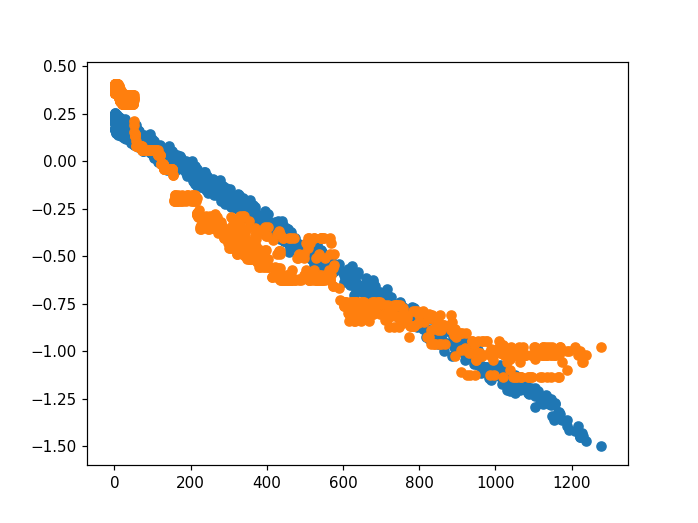

['PPFD_Avg', 'VPD', 'VWC', 'Shrub']
0.039062814178137624
0.8630839687323987


In [333]:
fco2.Project(Projector = None,Model = None)
# fco2.Project(Projector = None,Model = None)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(fco2.RST.Data[fco2.params['Inputs']],fco2.RST.Data[fco2.params['target']])


y_pred = reg.predict(fco2.RST.Data[fco2.params['Inputs']])
print(metrics.mean_squared_error(y_pred,fco2.RST.Data[fco2.params['target']]))
print(metrics.r2_score(fco2.RST.Data[fco2.params['target']],y_pred))
y_pred2 =  reg.predict(fco2.RST.Data[fco2.params['Inputs']])
# reg.coef_

# reg.intercept_ 

# reg.predict(np.array([[3, 5]]))
             
# print()
fco2.RST.Data['y_pred2']=y_pred2
plt.figure()
Var = 'Sedge'
Var = 'PPFD_Avg'
plt.scatter(fco2.RST.Data[Var],fco2.RST.Data['y_pred2'])


# import CART_Backend as Tree

# tree = Tree.Trees(fco2.RST.Data,'fco2',params['Inputs'])
# tree.Validate(kind='Tree',N_Max=15,step_size=1,ax=ax,iteration=15,min_samples_leaf=10)


from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_leaf_nodes= int(10),min_samples_leaf=30)
print(fco2.params['Inputs'])
forest.fit(fco2.RST.Data[fco2.params['Inputs']],fco2.RST.Data[fco2.params['target']])

y_pred = forest.predict(fco2.RST.Data[fco2.params['Inputs']])
y_pred3=forest.predict(fco2.RST.Data[fco2.params['Inputs']])
fco2.RST.Data['y_pred3']=y_pred3
plt.scatter(fco2.RST.Data[Var],fco2.RST.Data['y_pred3'])
print(metrics.mean_squared_error(y_pred,fco2.RST.Data[fco2.params['target']]))
print(metrics.r2_score(fco2.RST.Data[fco2.params['target']],y_pred))

In [607]:
# print(len(tarList))
columns=['VPD','VWC','Shrub']

4
